## CCS - final project - Jona Kao, Niclas Leinen
##### This jupyter notebook contains code for three different models. Use the following links to quickly get to the code of the different models and other sections of the code!

<b>[Libraries](#libraries)</b> \
<b>[Data Import](#data-import)</b> \
<b>[k and $\beta$](#k-and-beta-values)</b> \
<b>[Model 1: Ex-Gaussian model](#model-1-ex-gaussian-model)</b>

# Libraries
---

In [21]:
import scipy
from scipy.optimize import minimize
from scipy import stats
from scipy.stats import exponnorm
from scipy.stats import ks_1samp
from scipy.stats import ks_2samp
from scipy.stats import norm
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyddm
from pyddm import Sample

---
# Data import
---

We first define the path to the folder containing the sample data.

In [22]:
# Note: The given filepath is a RELATIVE filepath,
# meaning that the data folder must lie in the same
# directory as the jupyter notebook file!
data_path = "Data/"
mat_files = [f for f in os.listdir(data_path) if f.endswith(".mat")]

Then we create a function that loads and extracts the contents of a .mat-file.

In [23]:
def load_mat_file(file_path):
    mat_data = scipy.io.loadmat(file_path)

    # Extract data and convert to DataFrames
    data_train = pd.DataFrame(mat_data['data_train'])
    data_test = pd.DataFrame(mat_data['data_test'])
    data_labels = [label[0] for label in mat_data['data_labels'][0]]  # Convert to list of column names

    # Assign column names
    data_train.columns = data_labels
    data_test.columns = data_labels

    return data_train, data_test

Now we can load all the data into two dictionaries: <i>all_data_train</i> and <i>all_data_test</i>.

In [24]:
all_data_train = {}
all_data_test = {}

for mat_file in mat_files:
    file_path = os.path.join(data_path, mat_file)
    train, test = load_mat_file(file_path)
    
    # Store using participant ID (file name without .mat)
    participant_id = mat_file.replace(".mat", "")
    all_data_train[participant_id] = train
    all_data_test[participant_id] = test

We need to filter the data with a missing action value.

In [25]:
# Assuming all_data_train and all_data_test are dictionaries with participant IDs as keys
all_data_train_filtered = {}
all_data_test_filtered = {}

for participant_id, data in all_data_train.items():
    # Filter out rows where the action column has a value of 0
    filtered_data = data[data["action (1=immediate, 2=delayed, 0=missing)"] != 0]
    filtered_data = filtered_data.reset_index(drop=True)
    all_data_train_filtered[participant_id] = filtered_data

for participant_id, data in all_data_test.items():
    # Filter out rows where the action column has a value of 0
    filtered_data = data[data["action (1=immediate, 2=delayed, 0=missing)"] != 0]
    filtered_data = filtered_data.reset_index(drop=True)
    all_data_test_filtered[participant_id] = filtered_data

# Replace the original dictionaries with the filtered ones
all_data_train = all_data_train_filtered
all_data_test = all_data_test_filtered

The data is now fully loaded into <i>all_data_train</i> and <i>all_data_test</i> with the following layout: \
<i>data_set</i>[x] = data from participant x.

We will be using these datasets for all of our models.

---
# Figuring out values for $k$ and $\beta$
---

We will need the following formulas in order to calculate our values for $k$ and $\beta$:

(1) $sv_{delayed,i}$ = $\frac{delayed\_outcome}{1+k*delay}$

(2) $p_{delayed,i}$ = $\frac{1}{1+e^{-\beta(sv_{delayed} - sv_{immediate})}}$

(3) $log_L$ = $\sum_{i = 1}^n c_i log(p_{delayed,i}) + (1 - c_i) log(1-p_{delayed,i})$

Therefore, we will need to make some intital estimates for $k$ and $\beta$.
In this case, we chose random values using the random library, and we got the values $k = 0.000237$ and $\beta = 4.423591$

In [26]:
initial_k = 0.000237
initial_beta = 4.423591

We have to define the behaviour of the model when dealing with sample entries that are missing an <i>action</i>-value. (<i>action</i> = 0).
<ul>
    <li>Option 1: Set value to an <b>immediate</b> response.</li>
    <li>Option 2: Set value to a <b>delayed</b> response.</li>
    <li>Option 3: Set value to a <b>random</b> response.</li>
    <li>Option 4: <b>Ignore</b> entries with missing <i>action</i>-value</li>
</ul>

We went ahead with choosing option 1. As not many entries are missing <i>action</i>-value, the impact of this decision remains minimal, which we tested after we had successfully built our first model.

In [27]:
# Helper function to clamp action values between 0 and 1.
# Remaps action values of 2.0 to 1.0 (delayed) and all other values to 0.0 (immediate).
# This also covers the case of missing action values, which are treated as immediate.
def action_values_clamp01(actions):
    clamped_actions = []
    
    for action in actions:
        if action == 2.0:
            clamped_actions.append(1.0)
        else:
            clamped_actions.append(0.0)
    
    return clamped_actions

#### $k$-log-likelihood-function

In [28]:
def log_likelihood_k(k, data_set, participant):
    beta = initial_beta
    log_L = 0

    data_matrix = data_set[participant]
    
    sample_size = len(data_matrix)
    
    sv_immediates = data_matrix["immOutcome"]
    
    delayed_outcomes = data_matrix["delOutcome"]
    delays = data_matrix["delay"]
    actions = data_matrix["action (1=immediate, 2=delayed, 0=missing)"]
    clamped_actions = action_values_clamp01(actions)
    
    
    for i in range(sample_size):
        sv_delayed = delayed_outcomes[i] / (1.0 + k * max(delays[i], 1e-10))
        
        p_delayed = 1.0 / (1.0 + np.exp(-beta * (sv_delayed - sv_immediates[i])))
        p_delayed = np.clip(p_delayed, 1e-10, 1.0 - 1e-10)
        
        log_L += clamped_actions[i] * np.log(p_delayed) + (1.0 - clamped_actions[i]) * np.log(1.0 - p_delayed)

    return -log_L

Minimize $k$ values with this function:

In [29]:
k_results = []

for participant in all_data_train:
    result = minimize(log_likelihood_k, initial_k, args=(all_data_train, participant))
    k_results.append(result.x)

C:\Users\Nicla\AppData\Local\Temp\ipykernel_10632\3737937835.py:20: RuntimeWarning: overflow encountered in exp
  p_delayed = 1.0 / (1.0 + np.exp(-beta * (sv_delayed - sv_immediates[i])))
C:\Users\Nicla\AppData\Local\Temp\ipykernel_10632\3737937835.py:20: RuntimeWarning: overflow encountered in exp
  p_delayed = 1.0 / (1.0 + np.exp(-beta * (sv_delayed - sv_immediates[i])))
C:\Users\Nicla\AppData\Local\Temp\ipykernel_10632\3737937835.py:20: RuntimeWarning: overflow encountered in exp
  p_delayed = 1.0 / (1.0 + np.exp(-beta * (sv_delayed - sv_immediates[i])))
C:\Users\Nicla\AppData\Local\Temp\ipykernel_10632\3737937835.py:20: RuntimeWarning: overflow encountered in exp
  p_delayed = 1.0 / (1.0 + np.exp(-beta * (sv_delayed - sv_immediates[i])))
C:\Users\Nicla\AppData\Local\Temp\ipykernel_10632\3737937835.py:20: RuntimeWarning: overflow encountered in exp
  p_delayed = 1.0 / (1.0 + np.exp(-beta * (sv_delayed - sv_immediates[i])))
C:\Users\Nicla\AppData\Local\Temp\ipykernel_10632\3737937835

#### $\beta$-log-likelihood-function using calculated $k$-values <a id="m1_beta_llf"></a>

In [30]:
def log_likelihood_beta(beta, data_set, participant, participant_id):
    # Retrieve the k value for the current participant
    k = k_results[participant_id]
    log_L = 0

    # Get the data matrix for the current participant
    data_matrix = data_set[participant]
    
    # Determine the sample size
    sample_size = len(data_matrix)
    
    # Extract relevant columns from the data matrix
    sv_immediates = data_matrix["immOutcome"]
    delayed_outcomes = data_matrix["delOutcome"]
    delays = data_matrix["delay"]
    actions = data_matrix["action (1=immediate, 2=delayed, 0=missing)"]
    
    # Clamp action values to be between 0 and 1
    clamped_actions = action_values_clamp01(actions)

    # Loop through each sample in the data matrix
    for i in range(sample_size):
        # Calculate the subjective value of the delayed outcome
        sv_delayed = delayed_outcomes[i] / (1.0 + k * max(delays[i], 1e-10))
        
        # Calculate the probability of choosing the delayed outcome
        p_delayed = 1.0 / (1.0 + np.exp(-beta * (sv_delayed - sv_immediates[i])))
        p_delayed = np.clip(p_delayed, 1e-10, 1.0 - 1e-10)
        
        # Update the log likelihood
        log_L += clamped_actions[i] * np.log(p_delayed) + (1.0 - clamped_actions[i]) * np.log(1.0 - p_delayed)


    return -log_L

Minimize $\beta$ with this function:

In [31]:
# Initialize an empty list to store beta results
beta_results = []

i = 0

for participant in all_data_train:
    # Minimize the log likelihood function to find the best beta value
    result = minimize(log_likelihood_beta, initial_beta, args=(all_data_train, participant, i))
    beta_results.append(result.x)

    i += 1

C:\Users\Nicla\AppData\Local\Temp\ipykernel_10632\3174710902.py:27: RuntimeWarning: overflow encountered in exp
  p_delayed = 1.0 / (1.0 + np.exp(-beta * (sv_delayed - sv_immediates[i])))
C:\Users\Nicla\AppData\Local\Temp\ipykernel_10632\3174710902.py:27: RuntimeWarning: overflow encountered in exp
  p_delayed = 1.0 / (1.0 + np.exp(-beta * (sv_delayed - sv_immediates[i])))
C:\Users\Nicla\AppData\Local\Temp\ipykernel_10632\3174710902.py:27: RuntimeWarning: overflow encountered in exp
  p_delayed = 1.0 / (1.0 + np.exp(-beta * (sv_delayed - sv_immediates[i])))


We now have $k$ and $\beta$ values that we can universally use for all models.

---

# Accuracy test

---

In [32]:
def predict_choices(k, beta, participant):
    data_matrix = all_data_test[participant]

    sv_immediates = data_matrix["immOutcome"]
    delayed_outcomes = data_matrix["delOutcome"]
    delays = data_matrix["delay"]

    sample_size = len(data_matrix)
    
    predicted_choices = []
    
    # Loop through each sample in the data matrix
    for i in range(sample_size):
        # Calculate the subjective value of the delayed outcome
        sv_delayed = delayed_outcomes[i] / (1.0 + k * max(delays[i], 1e-10))
        
        # Calculate the probability of choosing the delayed outcome
        p_delayed = 1.0 / (1.0 + np.exp(-beta * (sv_delayed - sv_immediates[i])))
        p_delayed = np.clip(p_delayed, 1e-10, 1.0 - 1e-10)
        
        if p_delayed > 0.5:
            predicted_choices.append(1)
        else:
            predicted_choices.append(0)
    
    return predicted_choices

In [33]:
def predict_accuracies(k, beta, participant):
    predicted_choices = predict_choices(k, beta, participant)
    
    actions = all_data_test[participant]["action (1=immediate, 2=delayed, 0=missing)"]
    
    sample_size = len(actions)
    
    clamped_actions = action_values_clamp01(actions)

    correct_guesses = 0
    
    for i in range(sample_size):
        if clamped_actions[i] == predicted_choices[i]:
            correct_guesses += 1
    
    return correct_guesses / sample_size * 100

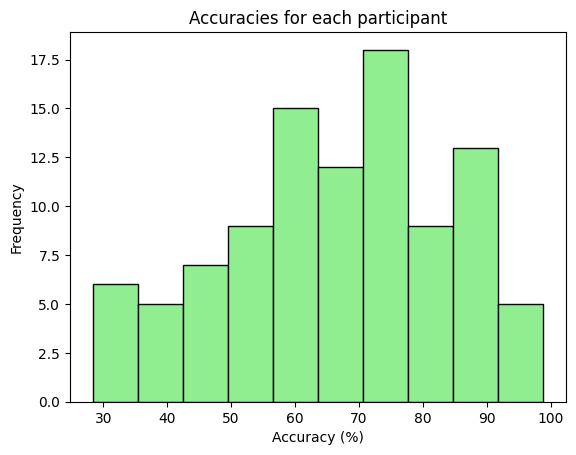

In [34]:
prediction_accuracies = []

for i, participant in enumerate(all_data_test):
    accuracy_score = predict_accuracies(k_results[i], beta_results[i], participant)
    prediction_accuracies.append(accuracy_score)

plt.hist(prediction_accuracies, bins=10, color="lightgreen", edgecolor="black")
plt.title("Accuracies for each participant")
plt.xlabel("Accuracy (%)")
plt.ylabel("Frequency")
plt.show()


---
# Distribution of reaction times
---

Another step we will need to do is extract all the reaction times from the dataset.

In [35]:
def get_reaction_times(data_set):
    reaction_times = []
    
    # Get reaction times from each participant in the training data
    for participant in data_set:
        data_matrix = all_data_train[participant]
        reaction_times.append((data_matrix["RT"]))
    
    return reaction_times

[DEBUG] Plotting reaction times for individual participants 

In [36]:
# plt.hist(reaction_times[56], bins=15, color="lightgreen", edgecolor="black")
# plt.title("Reaction Times")
# plt.xlabel("Reaction time (ms)")
# plt.ylabel("Frequency)")
# plt.grid()
# plt.show()

We can now get started with our first model!

---
# Model 1: Ex-Gaussian Model
---

Fit an Ex-Gaussian distribution to the reaction time data using scipy.exponnorm

In [37]:
reaction_times = get_reaction_times(all_data_train)

# Ensure each reaction_time_record is a 1-dimensional array and remove NaN values
reaction_times = [np.array(rt).flatten() for rt in reaction_times]
reaction_times = [rt[~np.isnan(rt)] for rt in reaction_times]

fits = []

for reaction_time_record in reaction_times:
    #fits.append(exponnorm.fit(reaction_time_record))
    fits.append(exponnorm.fit(reaction_time_record))

n = len(fits)

# Extracting the parameters
K_values = [fits[i][0] for i in range(n)]
loc_values = [fits[i][1] for i in range(n)]
scale_values = [fits[i][2] for i in range(n)]

tau_values = [K_values[i] * scale_values[i] for i in range(n)]
mu_values = loc_values
sigma_values = scale_values

## Testing the null hypothesis

In [38]:
# Initialize lists to store fitted CDFs, KS statistics, and p-values
fitted_cdfs = []
ks_statistics = []
p_values = []

# Loop through each set of K, mu, and sigma values
for i in range(len(K_values)):
    # Create a lambda function for the fitted CDF using the exponentially modified normal distribution
    fitted_cdfs.append(lambda x: exponnorm.cdf(x, K_values[i], loc=mu_values[i], scale=sigma_values[i]))
    
    # Perform the Kolmogorov-Smirnov test for goodness of fit
    ks_statistic, p_value = ks_1samp(reaction_times[i], fitted_cdfs[i])
    
    # Append the KS statistic and p-value to their respective lists
    ks_statistics.append(ks_statistic)
    p_values.append(p_value)


i = 0

for p_value in p_values:
    # Check if the p-value is less than 0.05 (significance level)
    if p_value < 0.05:
        print(f"Reject null hypothesis for participant with id {i}: {p_value:.4f}")

    i += 1

# [DEBUG] Print the mean of all p-values
# print(f"Mean of all p_values: {np.mean(p_values):.4f}")

Reject null hypothesis for participant with id 56: 0.0473


The null hyptothesis test demonstrates that the model holds true for all participants except for participant <b>#57</b>. \
The mean <i>p_value</i> lies at 0.7738. \
For every single other participant, the <i>p_value</i> is much greater than 0.05, meaning that there is an extremely small to no difference between our data and the ex-gaussian distribution. Therefore, we are going to use this approach to build our bimodal model.

## Creating a unified log-likelihood function

We first need to define the Ex-Gaussian-likelihood function:

In [39]:
def ex_gaussian_likelihood(participant_reaction_times, K_value, mu_value, sigma_value):
    return exponnorm.logpdf(participant_reaction_times, K_value, loc=mu_value, scale=sigma_value)

Then we can get the reaction time log-likelihoods by summing their individual likelihoods: 

In [40]:
reaction_times_likelihoods_train = []
reaction_times_log_likelihoods_train = []

for i in range(len(K_values)):
    reaction_times_likelihoods_train.append(ex_gaussian_likelihood(reaction_times[i], K_values[i], mu_values[i], sigma_values[i]))


for i in range(len(reaction_times_likelihoods_train)):
    likelihood = np.sum(reaction_times_likelihoods_train[i])
    reaction_times_log_likelihoods_train.append(likelihood)

The joint-log-likelihood can be calculated by the expression  $$log_{L,i}(joint)=log_{L,i}(p_{delay, i}) + log_{L,i}(reactiontime_i)$$

In [41]:
def joint_log_likelihood_train(_, data_set, participant, i):
    log_L = 0
    beta = beta_results[i]
    k = k_results[i]
    
    # Initialize the log likelihood for the current participant
    Log_L_p_delay = 0
    
    # Get the data matrix for the current participant
    data_matrix = data_set[participant]
    # Determine the sample size
    sample_size = len(data_matrix)
    # Extract relevant columns from the data matrix
    
    sv_immediates = data_matrix["immOutcome"]
    delayed_outcomes = data_matrix["delOutcome"]
    delays = data_matrix["delay"]
    actions = data_matrix["action (1=immediate, 2=delayed, 0=missing)"]
    
    # Clamp action values to be between 0 and 1
    clamped_actions = action_values_clamp01(actions)
    
    # Loop through each sample in the data matrix
    for j in range(sample_size):
        # Calculate the subjective value of the delayed outcome
        sv_delayed = delayed_outcomes[j] / (1.0 + k * max(delays[j], 1e-10))
        
        # Calculate the probability of choosing the delayed outcome
        p_delayed = 1.0 / (1.0 + np.exp(-beta * (sv_delayed - sv_immediates[j])))
        p_delayed = np.clip(p_delayed, 1e-10, 1.0 - 1e-10)
        
        # Update the log likelihood for the current participant
        Log_L_p_delay += clamped_actions[j] * np.log(p_delayed) + (1.0 - clamped_actions[j]) * np.log(1.0 - p_delayed)
    
    # Update the overall log likelihood
    log_L += Log_L_p_delay
    log_L += reaction_times_log_likelihoods_train[i]
    
    return -log_L

In [42]:
# Initialize index and results list
i = 0
results_model_1 = []

# Loop through each participant in the training data
for participant in all_data_train:
    # Extract the initial parameters for the current participant
    initial_params = [
        np.ravel(mu_values[i])[0],
        np.ravel(sigma_values[i])[0],
        np.ravel(K_values[i])[0],
        np.ravel(beta_results[i])[0],
        np.ravel(k_results[i])[0]
    ]
    
    # Convert the initial parameters to a NumPy array
    initial_params = np.array(initial_params)
    
    # Minimize the joint_likelihood_single function for the current participant
    result = minimize(joint_log_likelihood_train, initial_params, args=(all_data_train, participant, i))
    
    # Append the result to the results list
    results_model_1.append(result.x)
    
    i += 1

C:\Users\Nicla\AppData\Local\Temp\ipykernel_10632\3411334189.py:29: RuntimeWarning: overflow encountered in exp
  p_delayed = 1.0 / (1.0 + np.exp(-beta * (sv_delayed - sv_immediates[j])))


Now let's look at the results:

In [43]:
for result in results_model_1:
    print(f"mu_value = {result[0]}")
    print(f"sigma_value = {result[1]}")
    print(f"K_value = {result[2]}")
    print(f"beta_result = {result[3]}")
    print(f"k_result = {result[4]}")
    print("--------------------------------")

mu_value = 1124.411519559799
sigma_value = 123.00409758054138
K_value = 8.077244239687069
beta_result = 0.29562518373795793
k_result = 0.010523715118018029
--------------------------------
mu_value = 1076.96627751129
sigma_value = 186.47762779805484
K_value = 4.075080173557125
beta_result = 29.623241855373305
k_result = 0.03187023080155287
--------------------------------
mu_value = 1994.4924036316681
sigma_value = 154.45720601708138
K_value = 5.219455817732749
beta_result = 4.466463370616466
k_result = 0.0013528463912901097
--------------------------------
mu_value = 978.126210908872
sigma_value = 205.21747061542436
K_value = 1.5685861476037928
beta_result = 6.025890903377863
k_result = 0.009683458841085422
--------------------------------
mu_value = 1460.0616972811622
sigma_value = 243.2063450785744
K_value = 2.013396633125497
beta_result = 1.8123768351667398
k_result = 0.00941847794829452
--------------------------------
mu_value = 1749.990073937292
sigma_value = 354.64113300842575


### Note: high values of beta are the result of very small differences between immediate and non-delayed outcomes.  

---

# Testing Model 1

---

In order to test the model, we need to extract the reaction times from the test dataset first.

In [44]:
reaction_times_test = get_reaction_times(all_data_test)

reaction_times_likelihoods_train_test = []
reaction_times_log_likelihoods_test = []

for i in range(len(K_values)):
    reaction_times_likelihoods_train_test.append(ex_gaussian_likelihood(reaction_times_test[i], results_model_1[i][2], results_model_1[i][0], results_model_1[i][1]))


for i in range(len(reaction_times_likelihoods_train_test)):
    likelihood = np.sum(reaction_times_likelihoods_train_test[i])
    reaction_times_log_likelihoods_test.append(likelihood)

In [45]:
def joint_log_likelihood_test(_, data_set, participant, i):
    log_L = 0
    beta = results_model_1[i][3]
    k = results_model_1[i][4]
    
    # Initialize the log likelihood for the current participant
    Log_L_p_delay = 0
    
    # Get the data matrix for the current participant
    data_matrix = data_set[participant]
    # Determine the sample size
    sample_size = len(data_matrix)
    # Extract relevant columns from the data matrix
    
    sv_immediates = data_matrix["immOutcome"]
    delayed_outcomes = data_matrix["delOutcome"]
    delays = data_matrix["delay"]
    actions = data_matrix["action (1=immediate, 2=delayed, 0=missing)"]
    
    # Clamp action values to be between 0 and 1
    clamped_actions = action_values_clamp01(actions)
    
    # Loop through each sample in the data matrix
    for j in range(sample_size):
        # Calculate the subjective value of the delayed outcome
        sv_delayed = delayed_outcomes[j] / (1.0 + k * max(delays[j], 1e-10))
        
        # Calculate the probability of choosing the delayed outcome
        p_delayed = 1.0 / (1.0 + np.exp(-beta * (sv_delayed - sv_immediates[j])))
        p_delayed = np.clip(p_delayed, 1e-10, 1.0 - 1e-10)
        
        # Update the log likelihood for the current participant
        Log_L_p_delay += clamped_actions[j] * np.log(p_delayed) + (1.0 - clamped_actions[j]) * np.log(1.0 - p_delayed)
    
    # Update the overall log likelihood
    log_L += Log_L_p_delay
    log_L += reaction_times_log_likelihoods_test[i]
    
    return log_L

In [46]:
# Initialize index and results list
i = 0
test_results_model_1 = []

# Loop through each participant in the training data
for participant in all_data_test:
    # Extract the initial parameters for the current participant
    initial_params = [
        np.ravel(results_model_1[i])[0],
        np.ravel(results_model_1[i])[1],
        np.ravel(results_model_1[i])[2],
        np.ravel(results_model_1[i])[3],
        np.ravel(results_model_1[i])[4]
    ]
    
    # Convert the initial parameters to a NumPy array
    initial_params = np.array(initial_params)
    
    # Minimize the joint_likelihood_single function for the current participant
    result = joint_log_likelihood_test(None, all_data_test, participant, i)
    
    # Append the result to the results list
    test_results_model_1.append(result)
    
    i += 1

### AIC & BIC values for model comparison

In [47]:
def compute_aic_bic_model_1(log_likelihood, num_params, num_trials):
    AIC = 2 * num_params - 2 * log_likelihood
    BIC = num_params * np.log(num_trials) - 2 * log_likelihood
    
    return AIC, BIC

num_params_model_1 = 5


for i, participant in enumerate(all_data_train):
    joint_log_likelihood_model_1 = joint_log_likelihood_train(None, all_data_train, participant, i)
    num_trials = len(all_data_train[participant])
    
    aic, bic = compute_aic_bic_model_1(-joint_log_likelihood_model_1, num_params_model_1, num_trials)

C:\Users\Nicla\AppData\Local\Temp\ipykernel_10632\3411334189.py:29: RuntimeWarning: overflow encountered in exp
  p_delayed = 1.0 / (1.0 + np.exp(-beta * (sv_delayed - sv_immediates[j])))


### KS testing

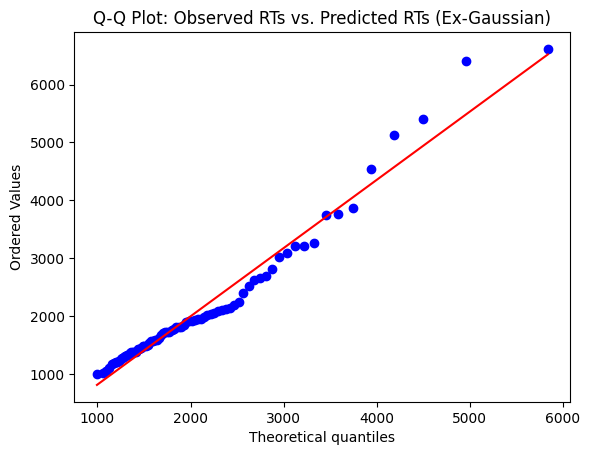

KS Stat: 0.12536651648430236, p-value: 0.32312735591417485


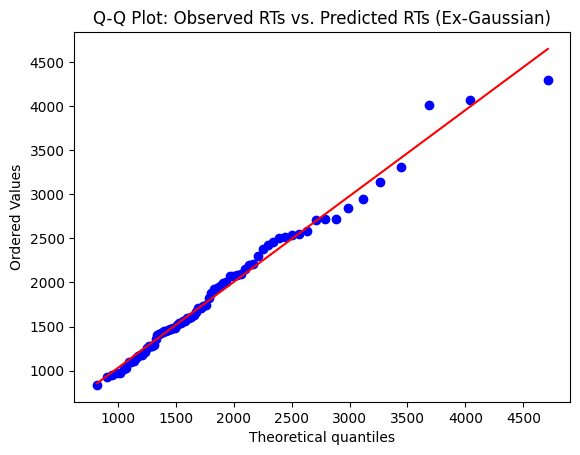

KS Stat: 0.13472222222222222, p-value: 0.24440489773404844


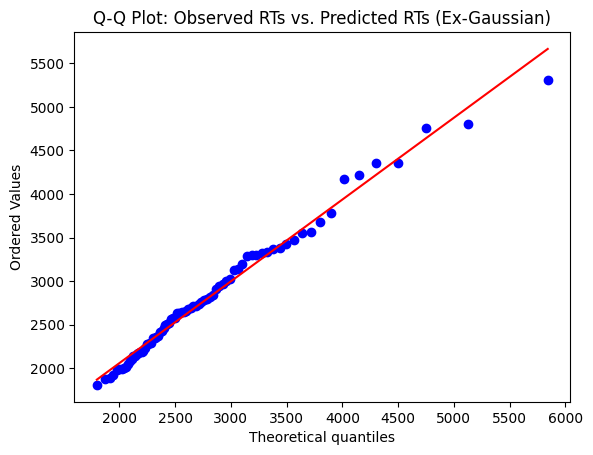

KS Stat: 0.06805555555555555, p-value: 0.9436414658007334


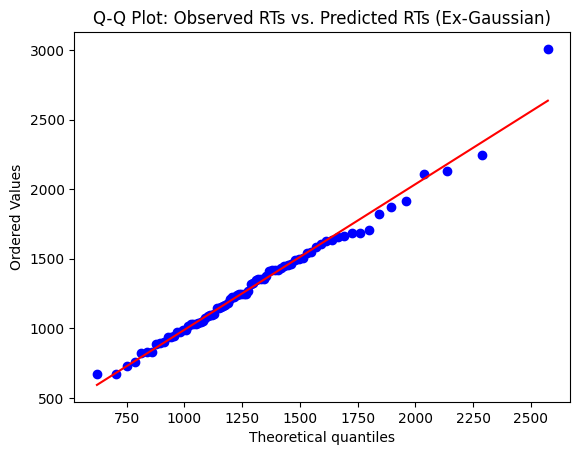

KS Stat: 0.10097765363128491, p-value: 0.5814878249086303


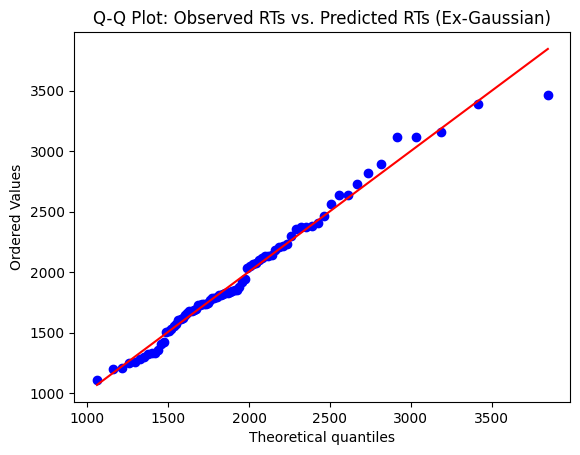

KS Stat: 0.09166666666666666, p-value: 0.7053386462695957


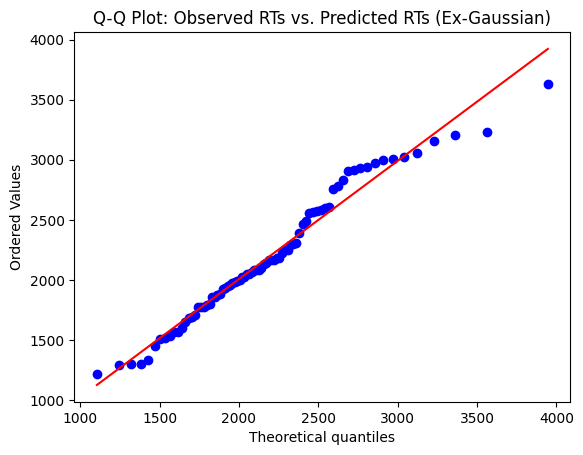

KS Stat: 0.09027777777777778, p-value: 0.7225335445345684


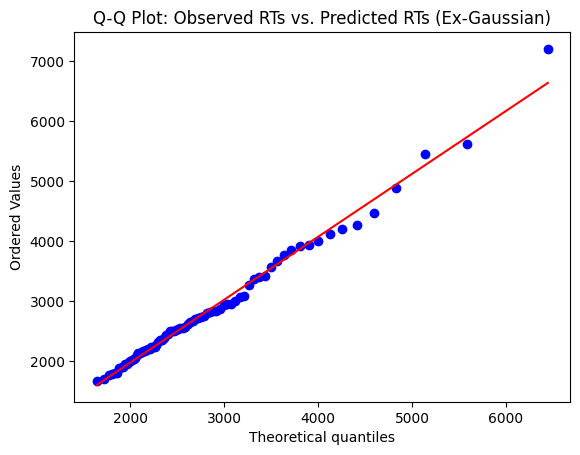

KS Stat: 0.10277777777777777, p-value: 0.566396787769197


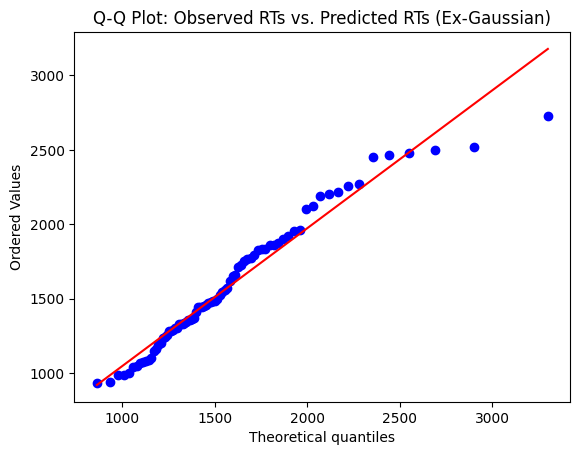

KS Stat: 0.12361111111111112, p-value: 0.3376191096608747


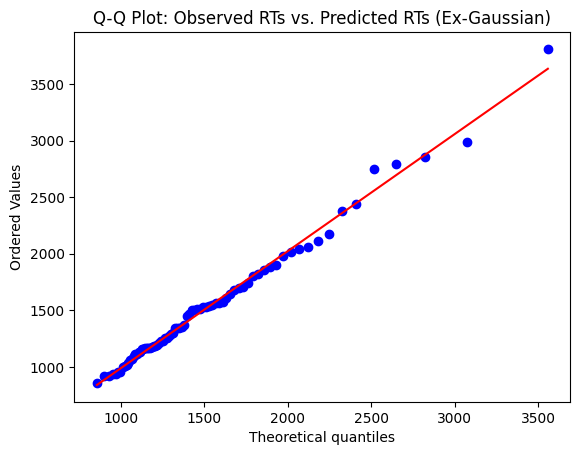

KS Stat: 0.11282051282051282, p-value: 0.45370062630042574


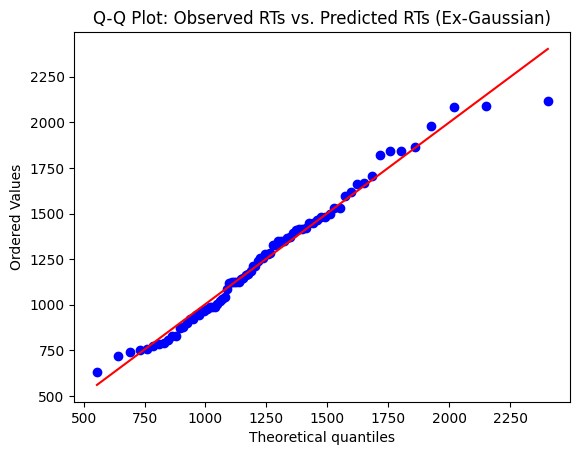

KS Stat: 0.1166184971098266, p-value: 0.4079921350108418


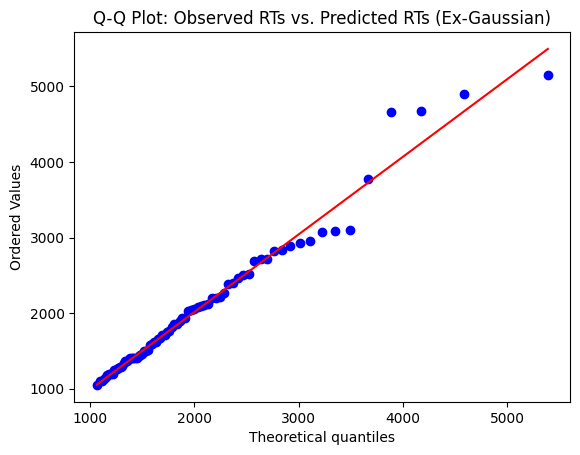

KS Stat: 0.06666666666666667, p-value: 0.9519923903178499


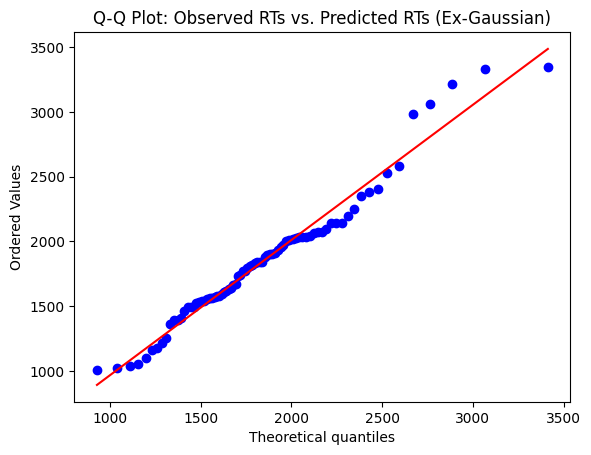

KS Stat: 0.09722222222222222, p-value: 0.6356331802024541


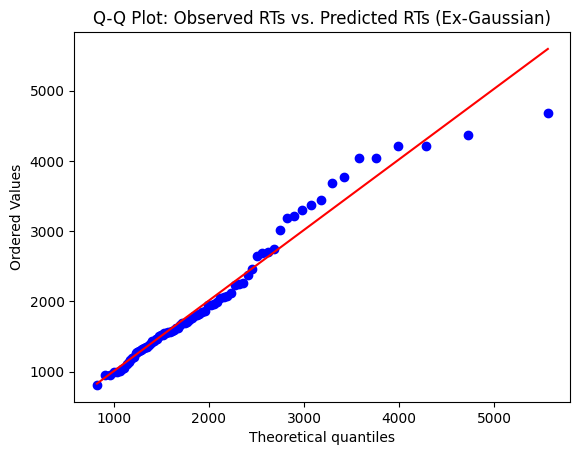

KS Stat: 0.08470670391061452, p-value: 0.7824357740617197


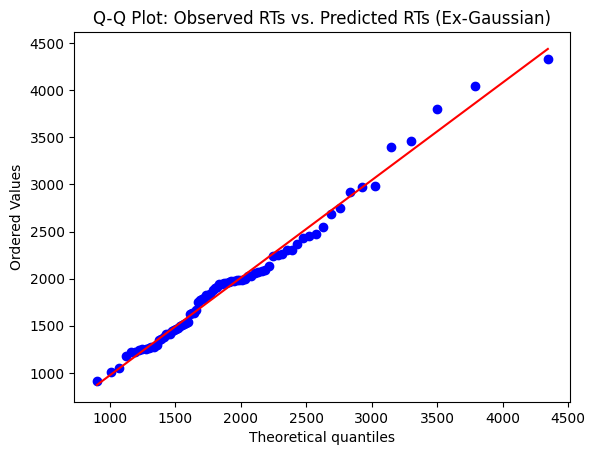

KS Stat: 0.07222222222222222, p-value: 0.9140406920247063


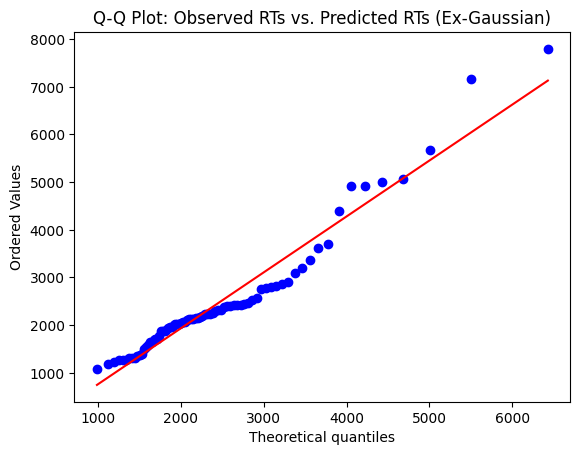

KS Stat: 0.13973277074542897, p-value: 0.20877263708328217


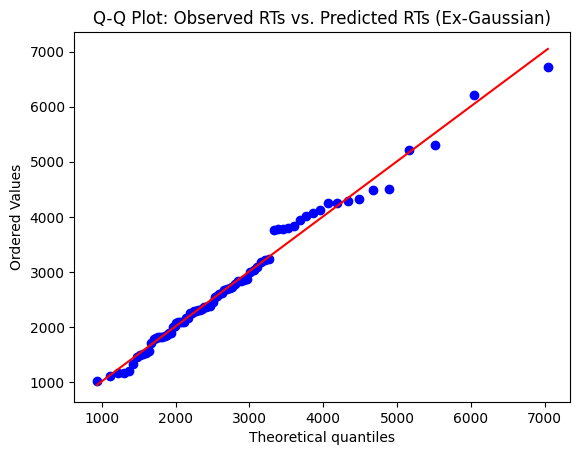

KS Stat: 0.09861111111111111, p-value: 0.6181700058680114


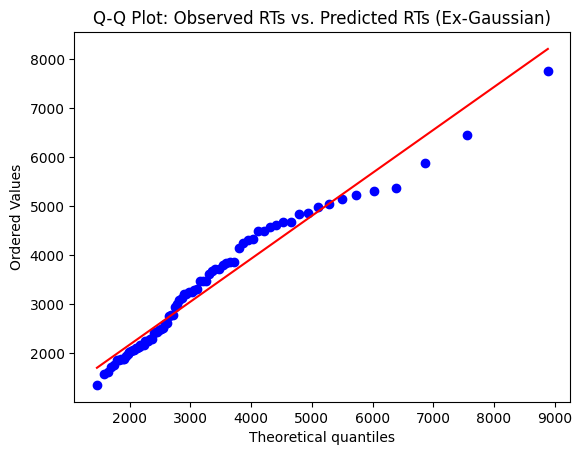

KS Stat: 0.10421348314606742, p-value: 0.542948384602126


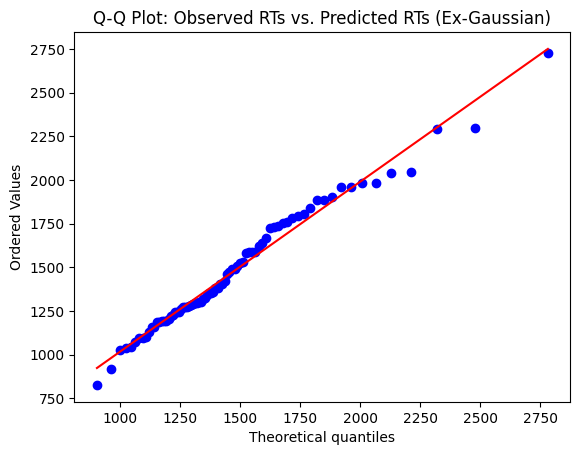

KS Stat: 0.06666666666666667, p-value: 0.9519923903178499


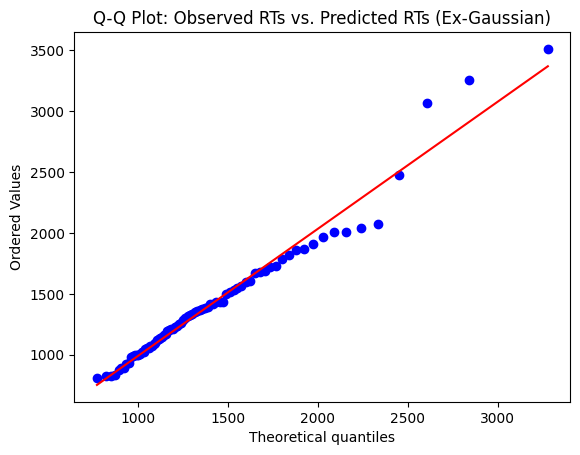

KS Stat: 0.04861111111111111, p-value: 0.9986015379101693


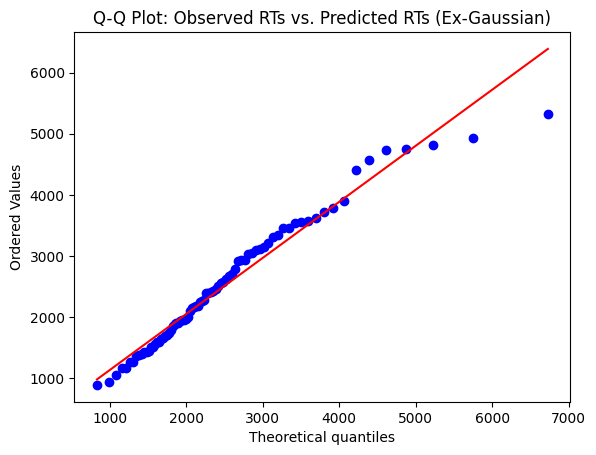

KS Stat: 0.08055555555555556, p-value: 0.8358014567101134


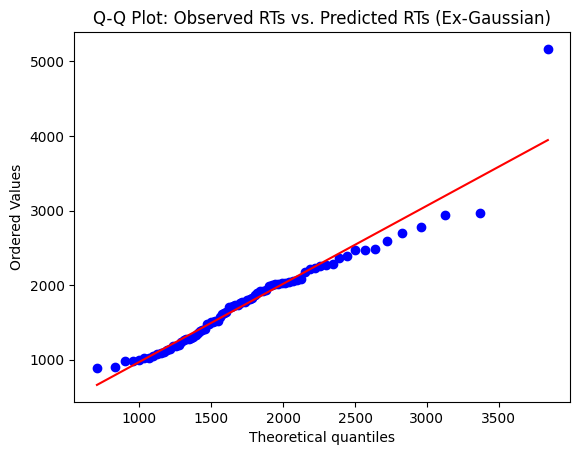

KS Stat: 0.14305555555555555, p-value: 0.18811058773227637


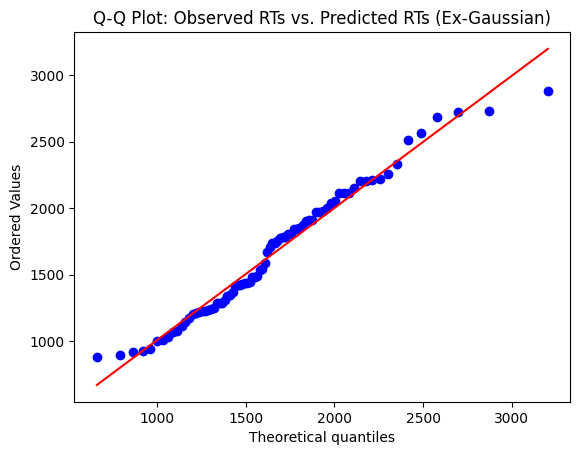

KS Stat: 0.1361111111111111, p-value: 0.23423801635726288


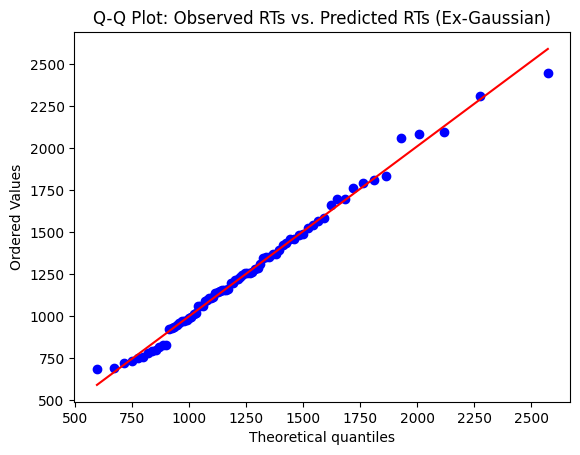

KS Stat: 0.07045454545454545, p-value: 0.928207940499943


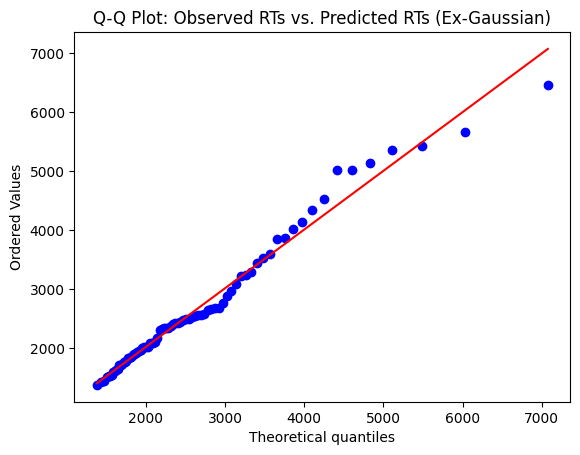

KS Stat: 0.12916666666666668, p-value: 0.2883479669907696


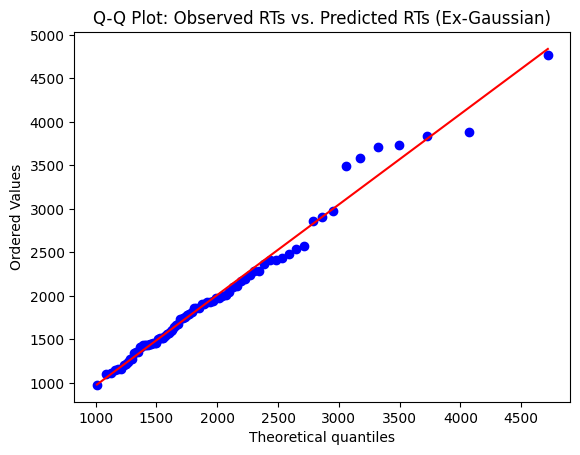

KS Stat: 0.08055555555555556, p-value: 0.8358014567101134


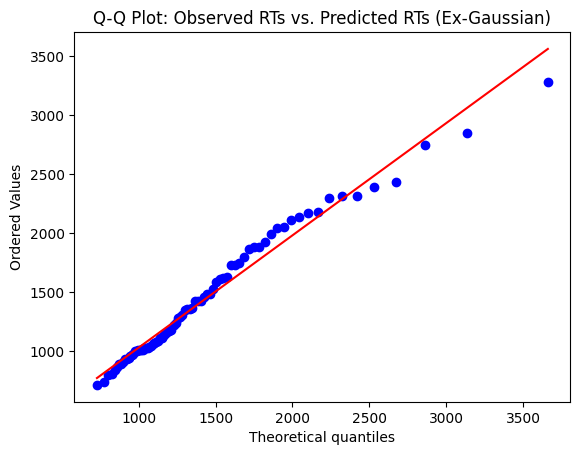

KS Stat: 0.10138888888888889, p-value: 0.5835158683358517


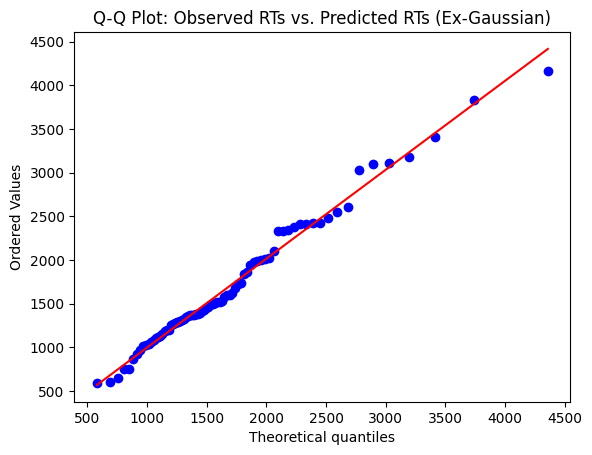

KS Stat: 0.09166666666666666, p-value: 0.7053386462695957


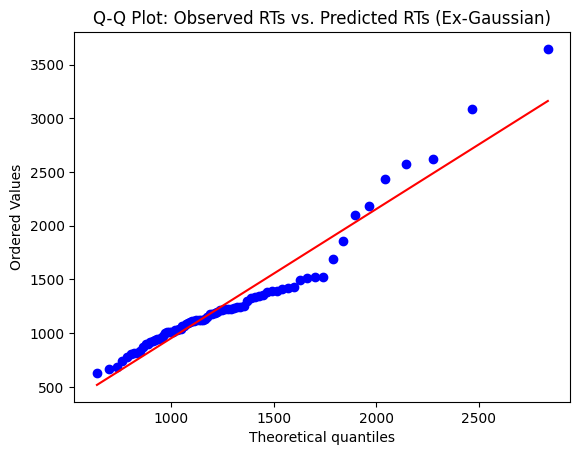

KS Stat: 0.13333333333333333, p-value: 0.2600494593973269


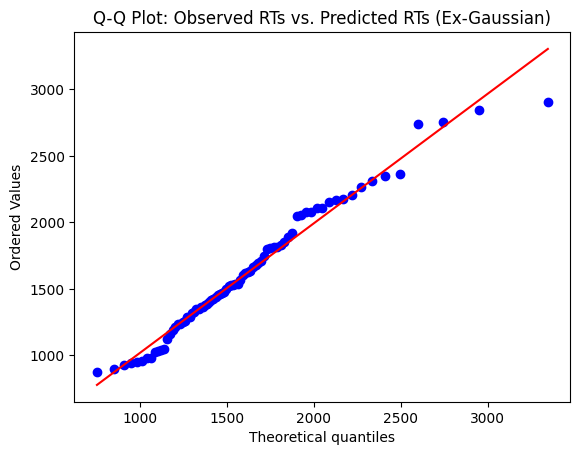

KS Stat: 0.09915254237288136, p-value: 0.605864563733679


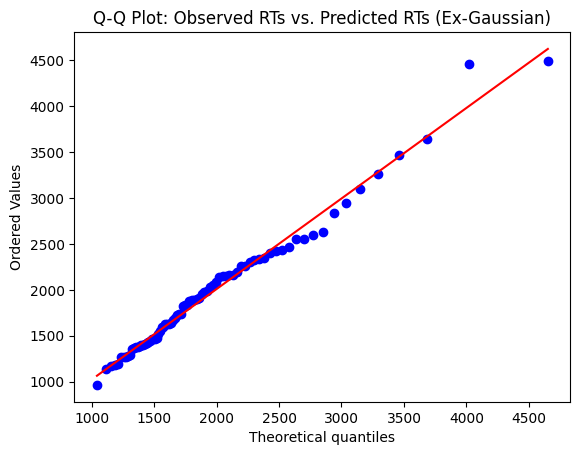

KS Stat: 0.05551675977653631, p-value: 0.9906276339614446


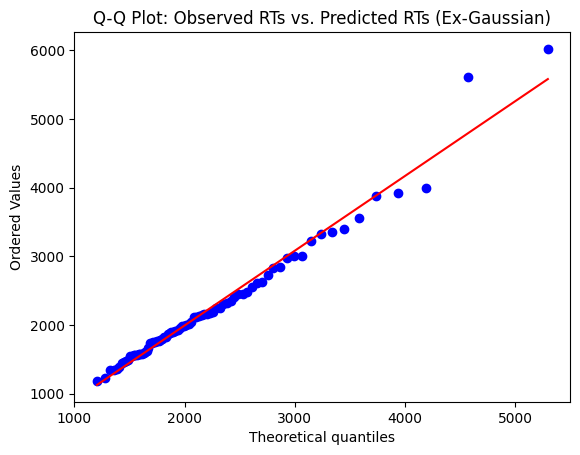

KS Stat: 0.09027777777777778, p-value: 0.7225335445345684


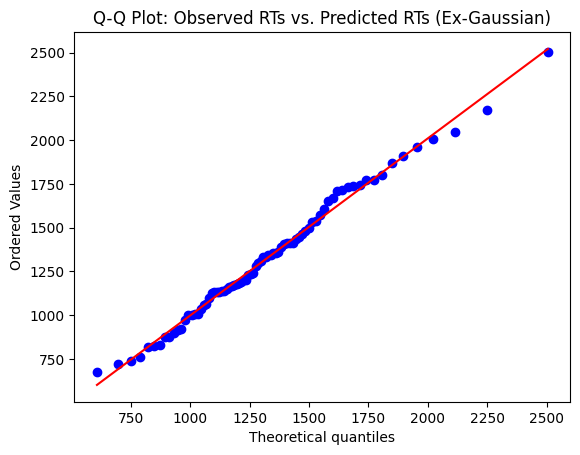

KS Stat: 0.07083333333333333, p-value: 0.9247490409238771


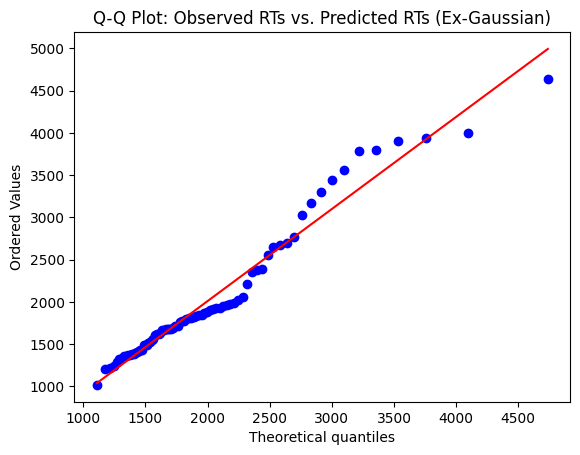

KS Stat: 0.08472222222222223, p-value: 0.7892870617465509


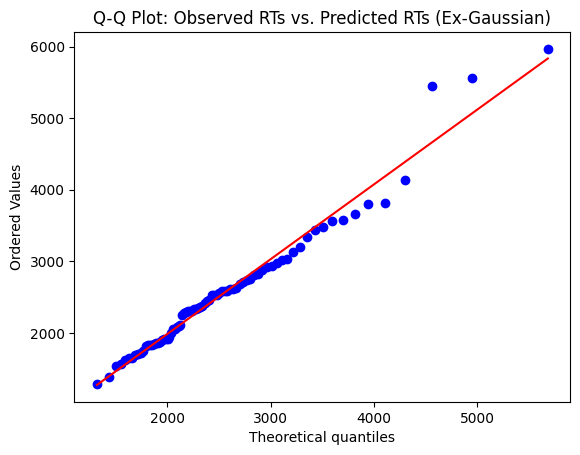

KS Stat: 0.07653631284916201, p-value: 0.8705394927550015


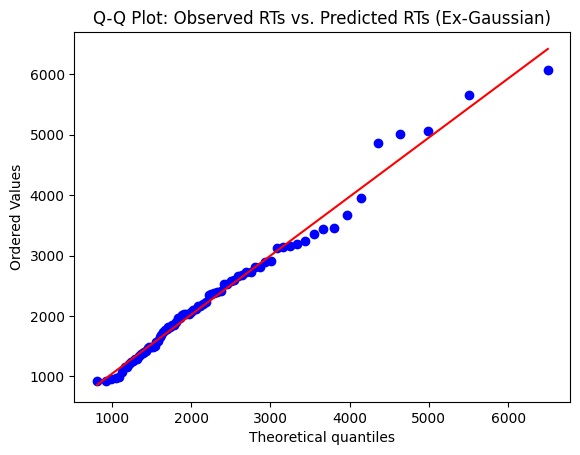

KS Stat: 0.09583333333333334, p-value: 0.6530720410075813


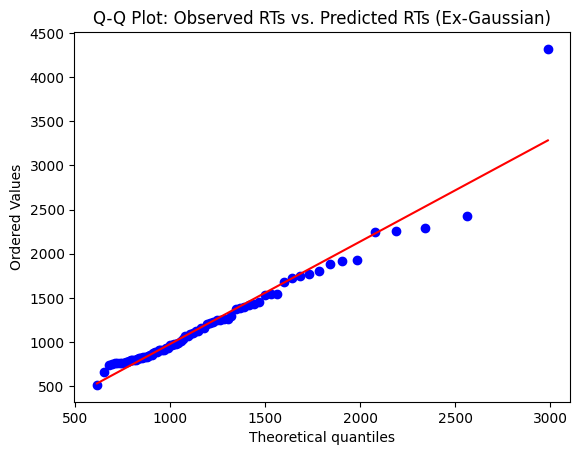

KS Stat: 0.11388888888888889, p-value: 0.4364842796716934


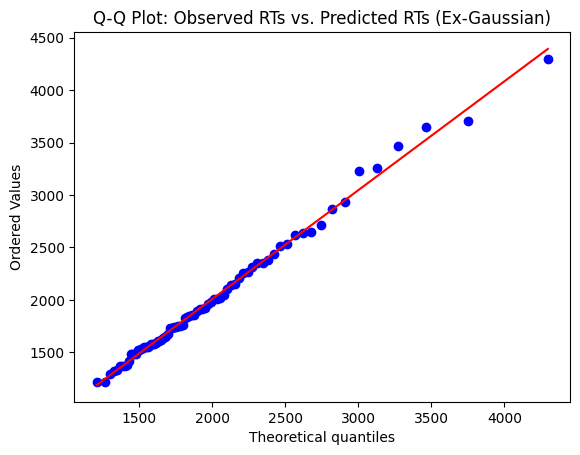

KS Stat: 0.08611111111111111, p-value: 0.7730365118473057


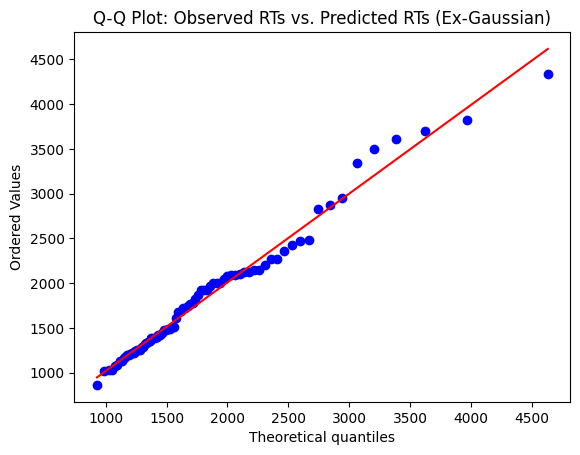

KS Stat: 0.10694444444444444, p-value: 0.5159351596736678


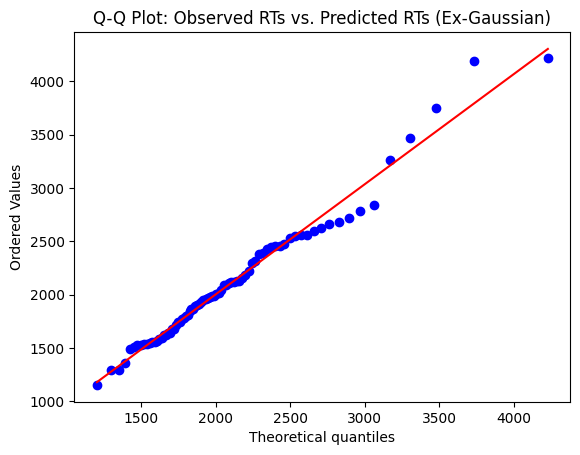

KS Stat: 0.06111111111111111, p-value: 0.9774716443685811


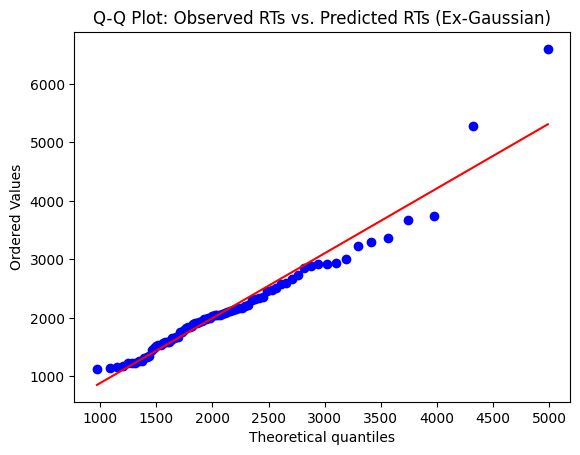

KS Stat: 0.075, p-value: 0.8905703045715126


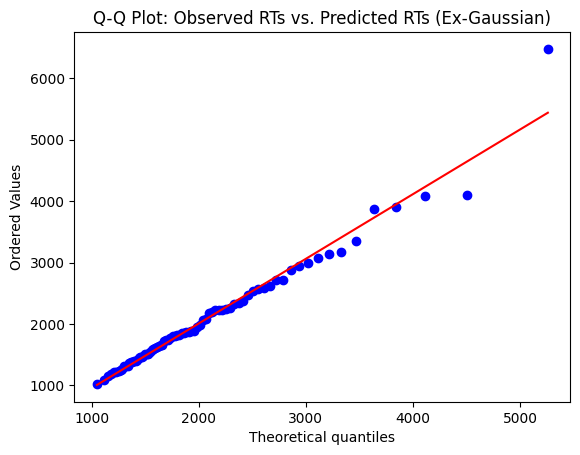

KS Stat: 0.05138888888888889, p-value: 0.9968907120239306


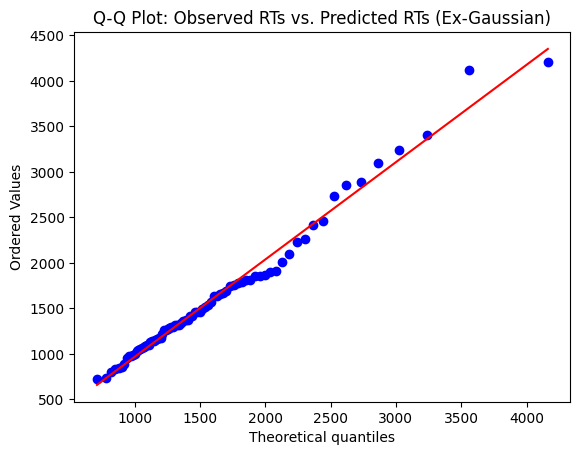

KS Stat: 0.1527777777777778, p-value: 0.13580170611847012


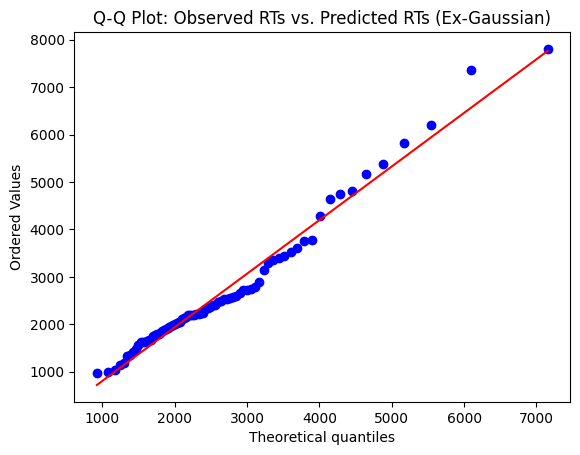

KS Stat: 0.08333333333333333, p-value: 0.8052146057453451


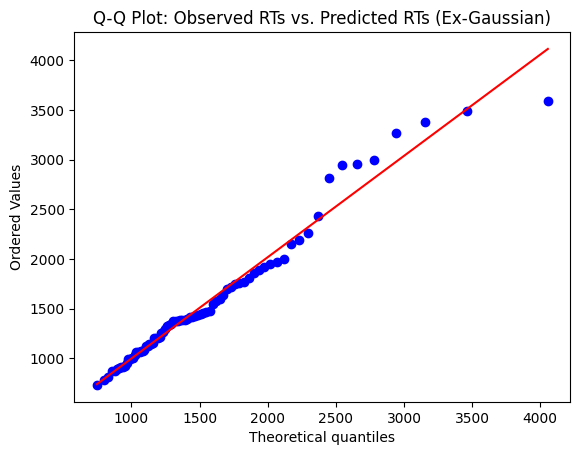

KS Stat: 0.07222222222222222, p-value: 0.9140406920247063


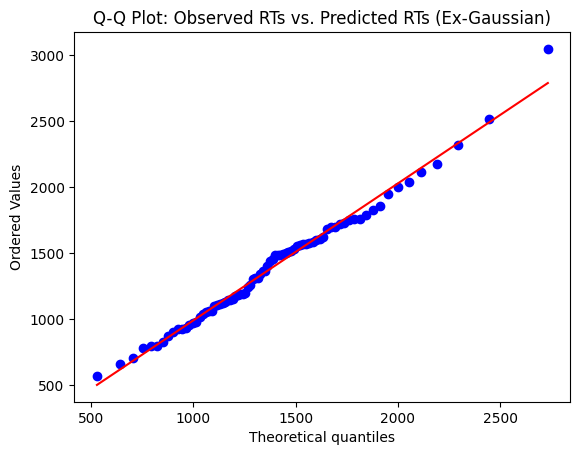

KS Stat: 0.08333333333333333, p-value: 0.8052146057453451


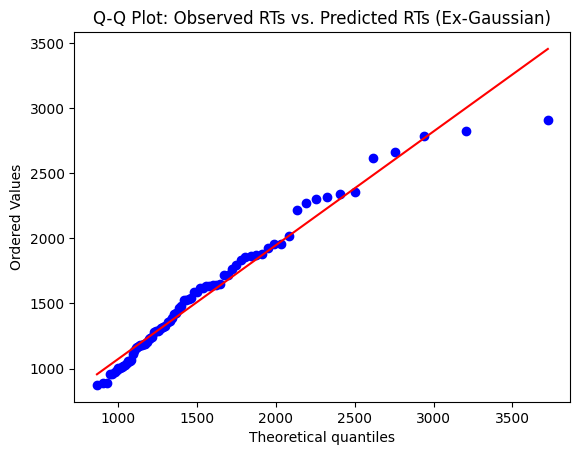

KS Stat: 0.1111111111111111, p-value: 0.4674695237127266


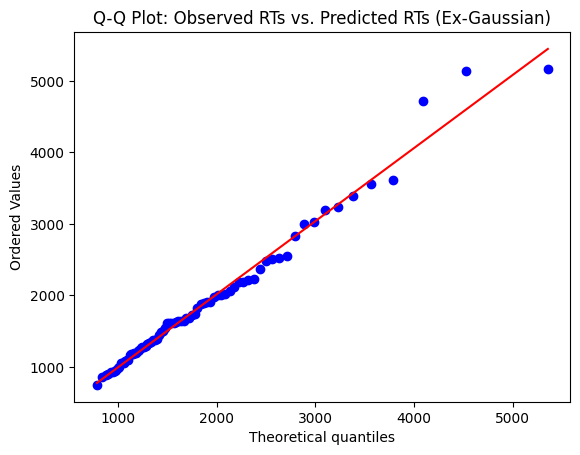

KS Stat: 0.07361111111111111, p-value: 0.9026088647539694


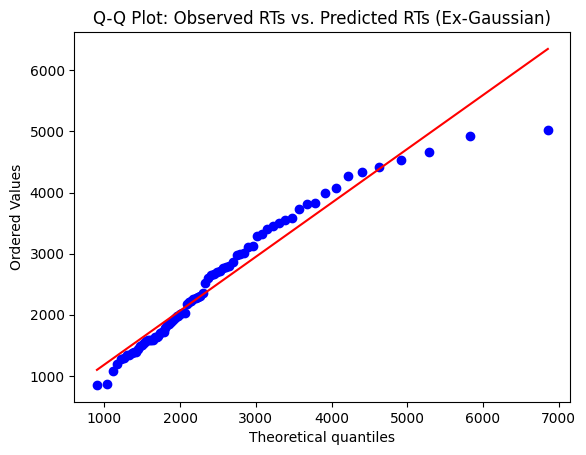

KS Stat: 0.09002192207057493, p-value: 0.7230957971181139


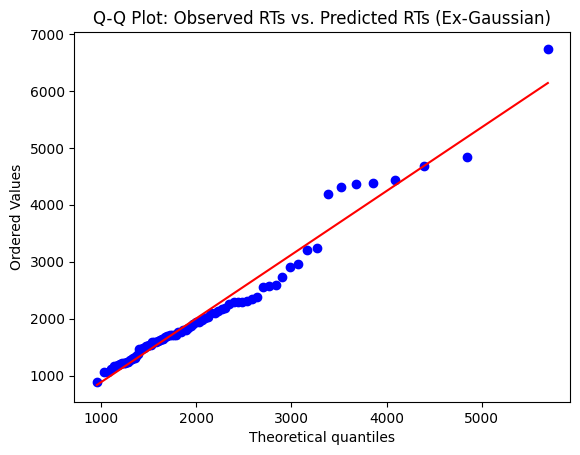

KS Stat: 0.1388888888888889, p-value: 0.2148544228367713


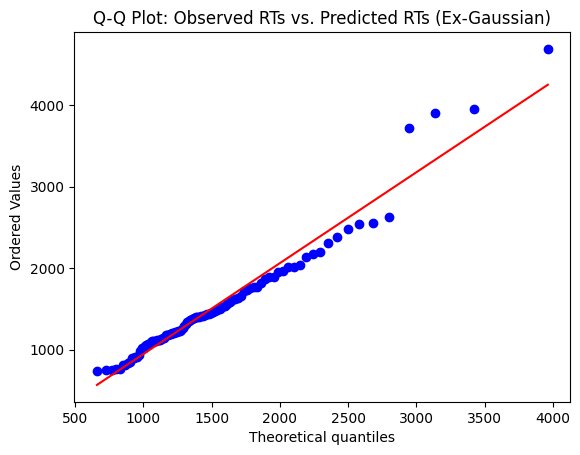

KS Stat: 0.0775, p-value: 0.7644628448477951


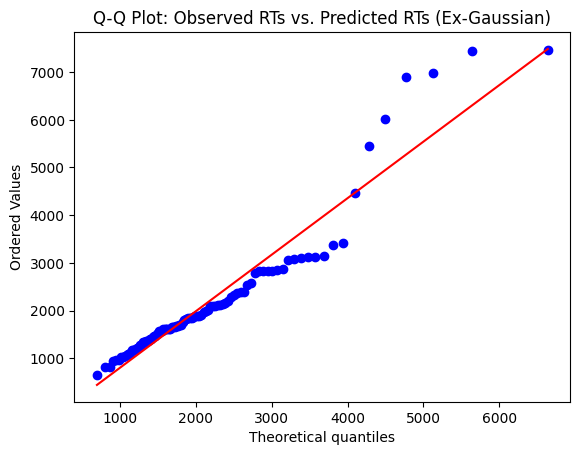

KS Stat: 0.10111111111111111, p-value: 0.4490332863594763


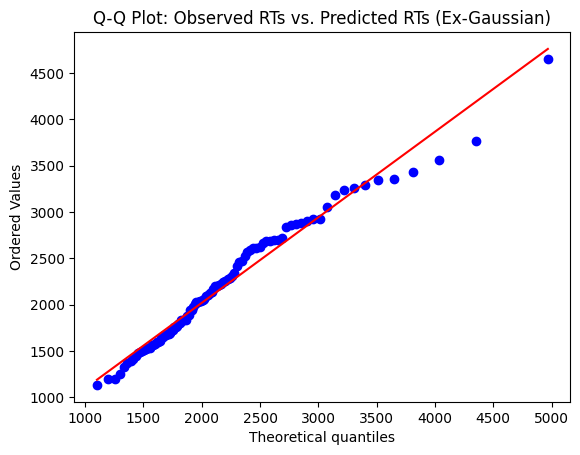

KS Stat: 0.08777777777777777, p-value: 0.627710541064128


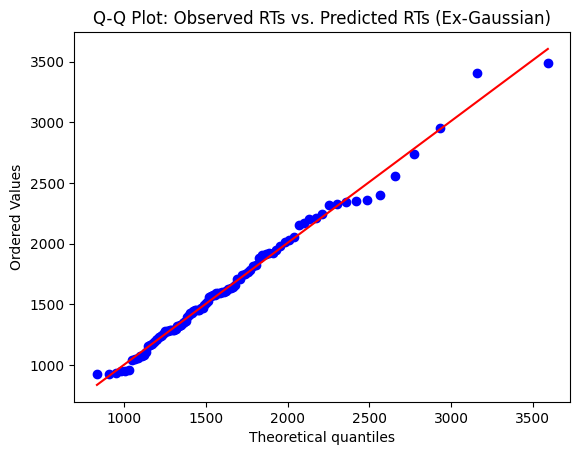

KS Stat: 0.10982142857142857, p-value: 0.3441080996906335


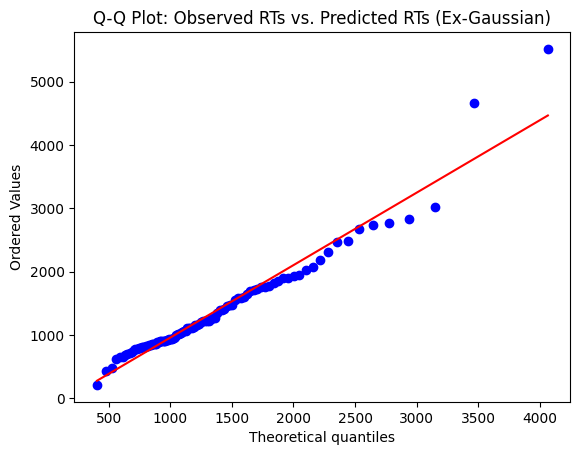

KS Stat: 0.061964285714285715, p-value: 0.9342751520713132


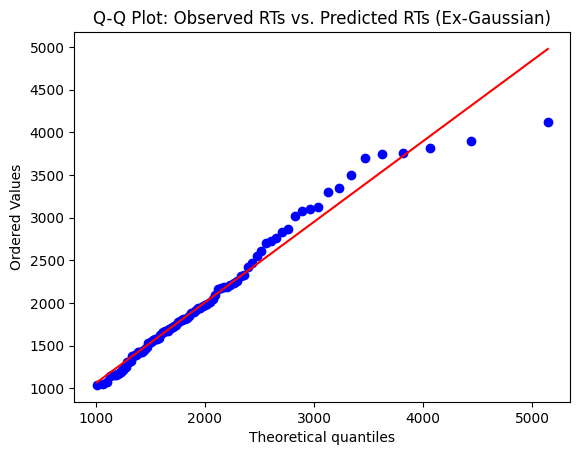

KS Stat: 0.07555555555555556, p-value: 0.7954026585469328


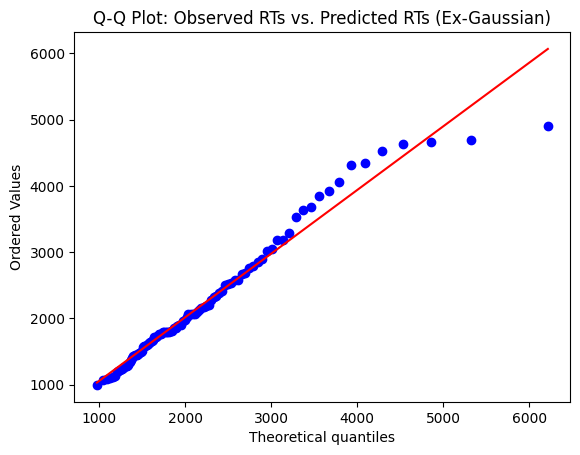

KS Stat: 0.07928571428571428, p-value: 0.7405945077318398


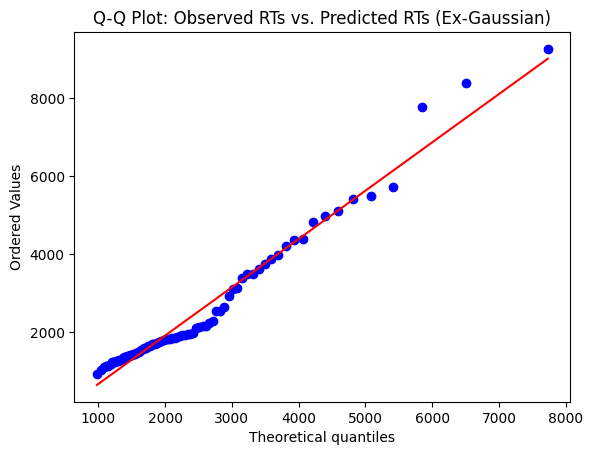

KS Stat: 0.15095046854083, p-value: 0.11158512100711386


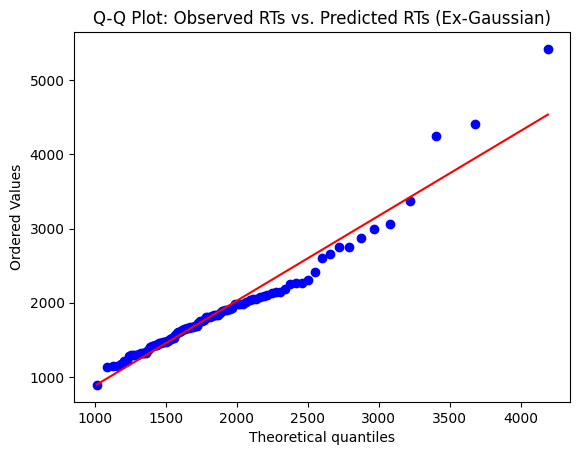

KS Stat: 0.07923444976076555, p-value: 0.7510834211982013


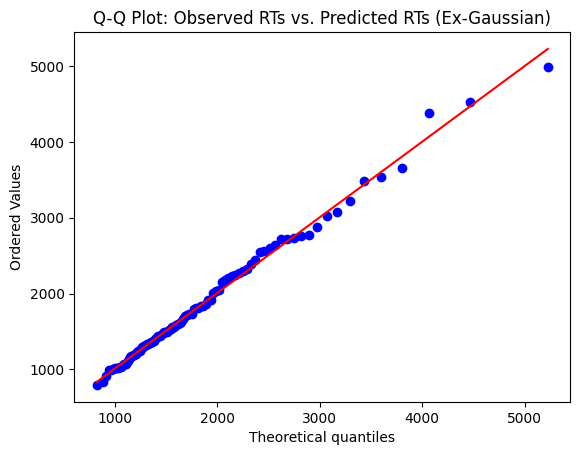

KS Stat: 0.07191919191919192, p-value: 0.8390817985019822


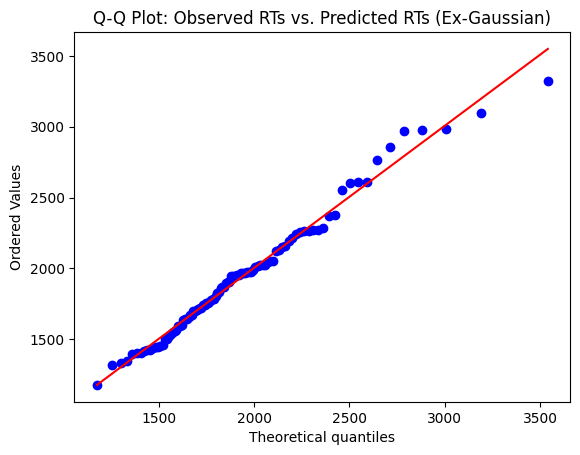

KS Stat: 0.08222222222222222, p-value: 0.7056302561718647


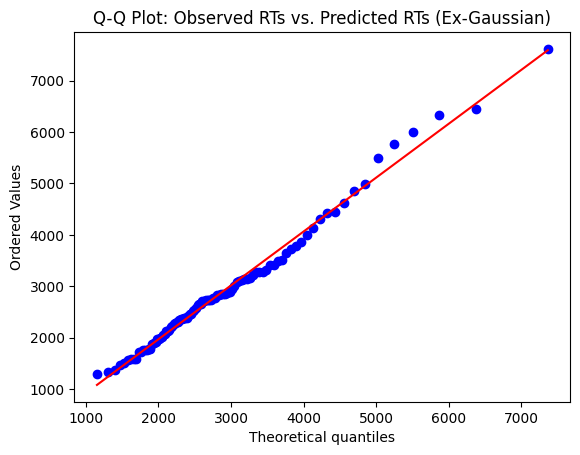

KS Stat: 0.09333333333333334, p-value: 0.5502394043984952


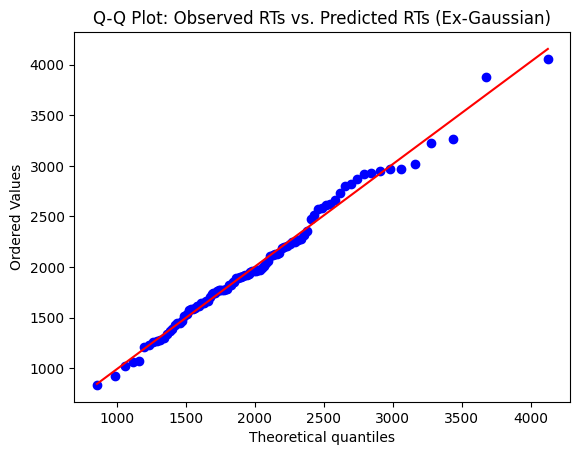

KS Stat: 0.08444444444444445, p-value: 0.6745356336654342


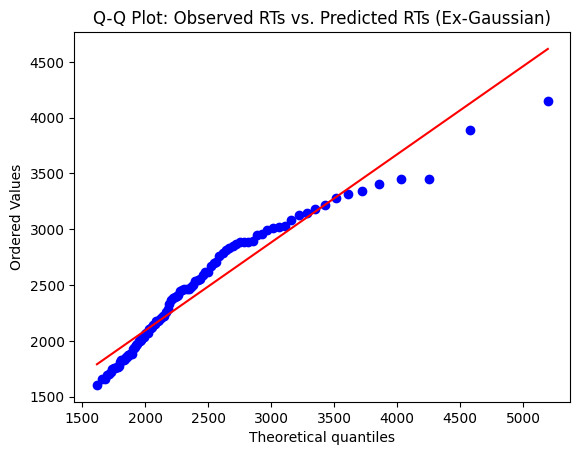

KS Stat: 0.11222222222222222, p-value: 0.3232693077100007


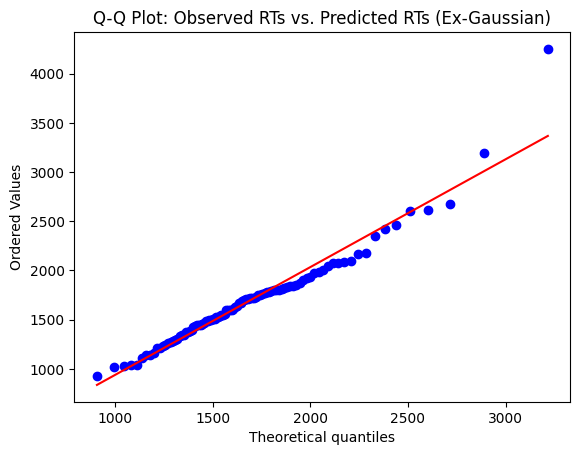

KS Stat: 0.08, p-value: 0.7352149863915445


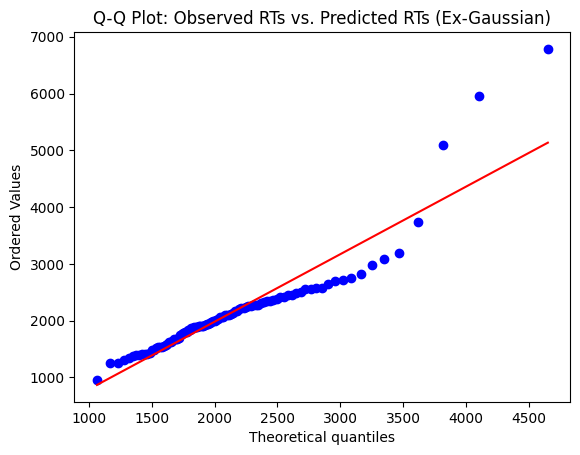

KS Stat: 0.13, p-value: 0.17850476640694093


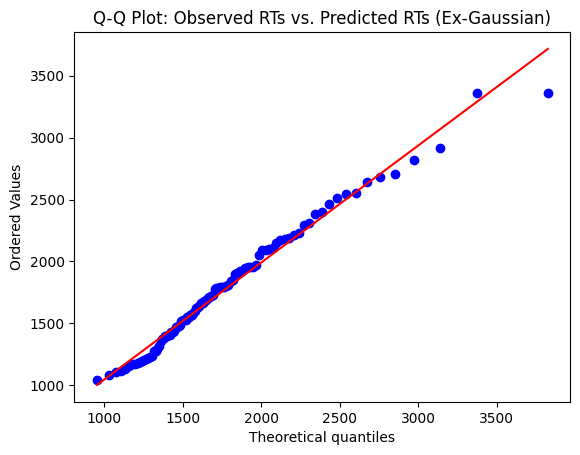

KS Stat: 0.08888888888888889, p-value: 0.6121331896918775


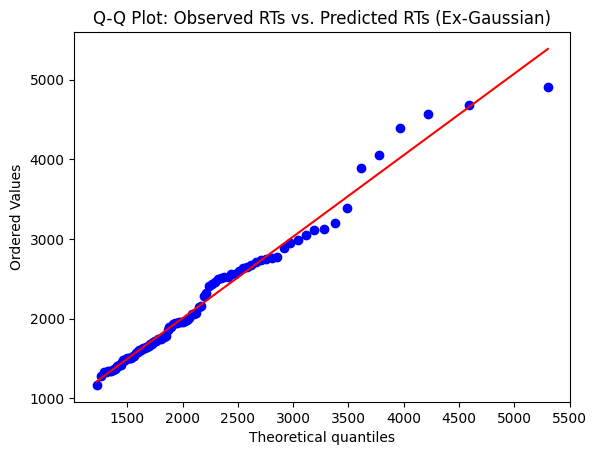

KS Stat: 0.06888888888888889, p-value: 0.8744351403296499


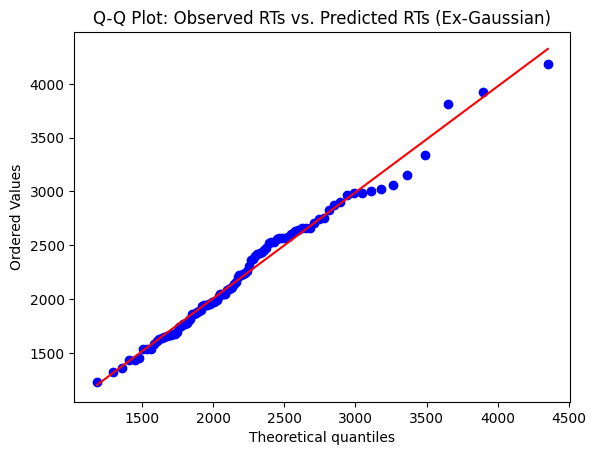

KS Stat: 0.09666666666666666, p-value: 0.5059949919419156


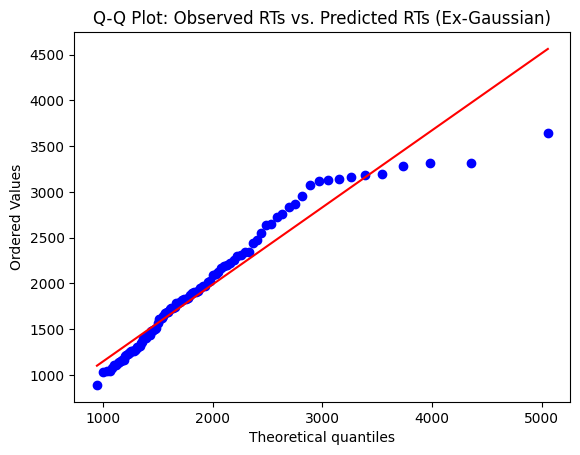

KS Stat: 0.06555555555555556, p-value: 0.9076228731163188


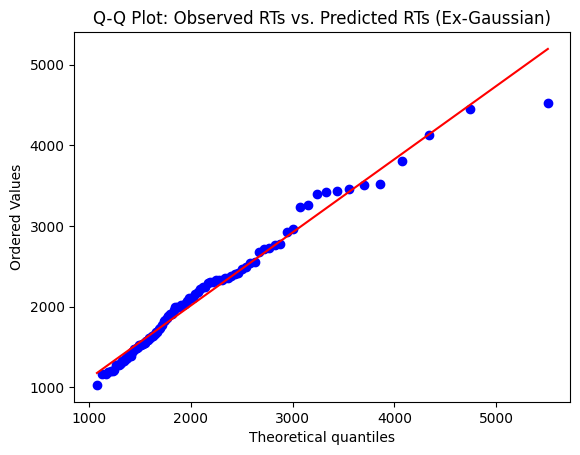

KS Stat: 0.0811111111111111, p-value: 0.7210130996130837


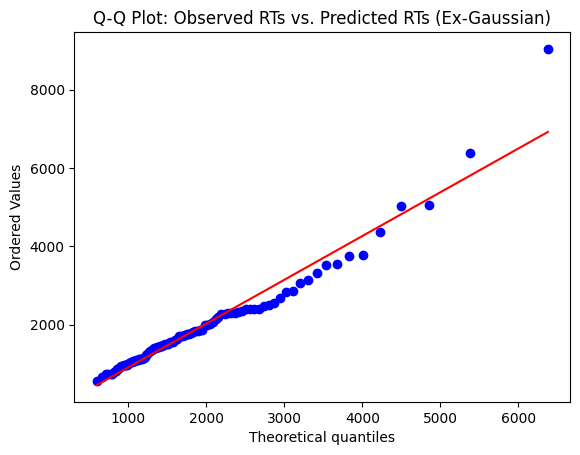

KS Stat: 0.07111111111111111, p-value: 0.8497400815034902


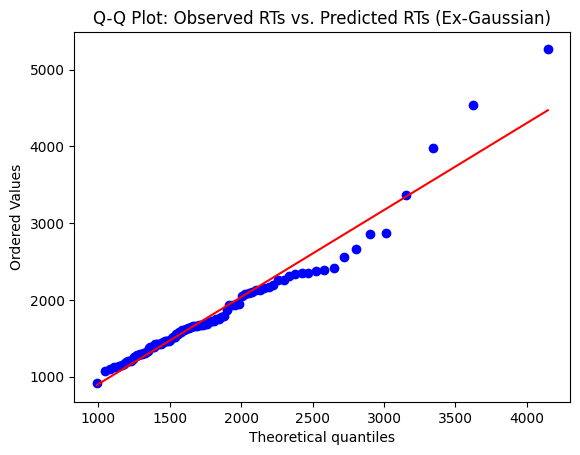

KS Stat: 0.06, p-value: 0.9512026946893348


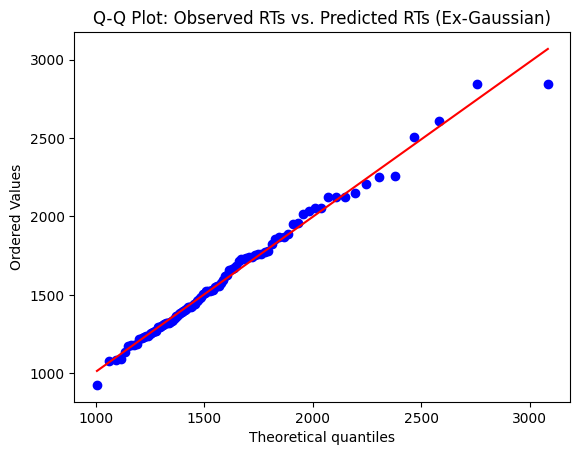

KS Stat: 0.06555555555555556, p-value: 0.9076228731163188


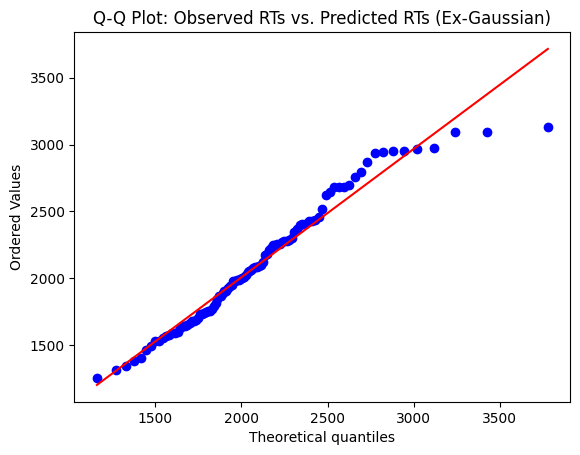

KS Stat: 0.10111111111111111, p-value: 0.4490332863594763


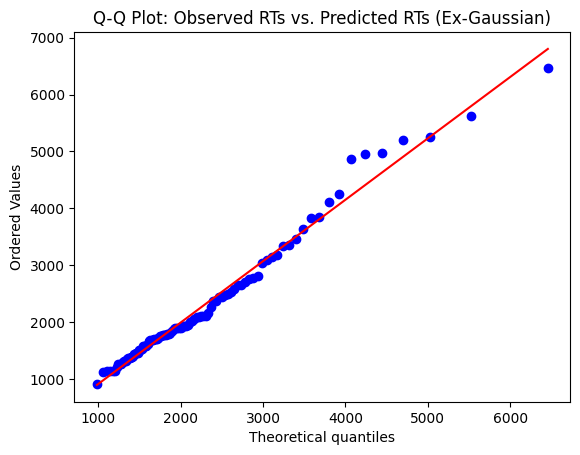

KS Stat: 0.08910313901345292, p-value: 0.603657443063328


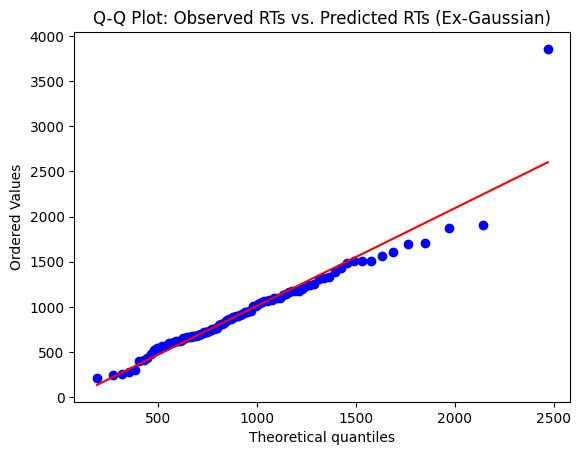

KS Stat: 0.06802690582959642, p-value: 0.8790252201013103


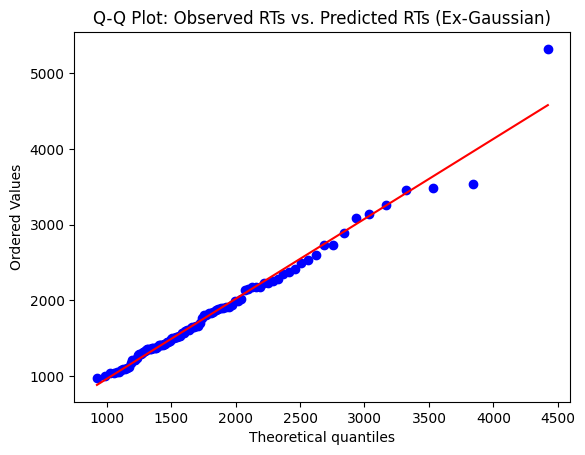

KS Stat: 0.06, p-value: 0.9512026946893348


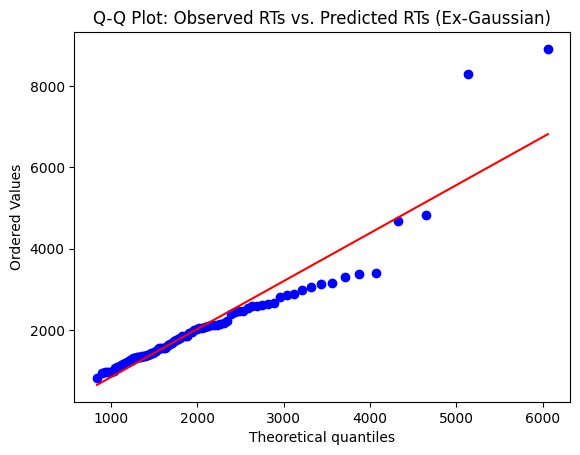

KS Stat: 0.07340501792114695, p-value: 0.8382390012957301


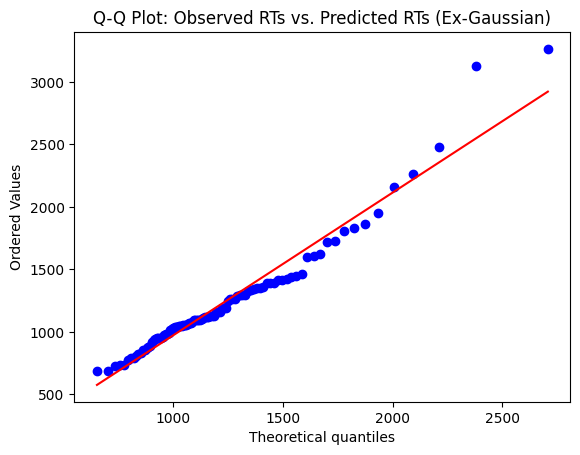

KS Stat: 0.06777777777777778, p-value: 0.886022457082521


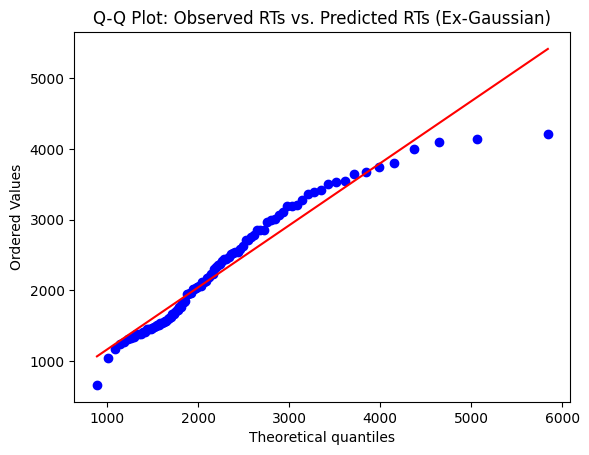

KS Stat: 0.07111111111111111, p-value: 0.8497400815034902


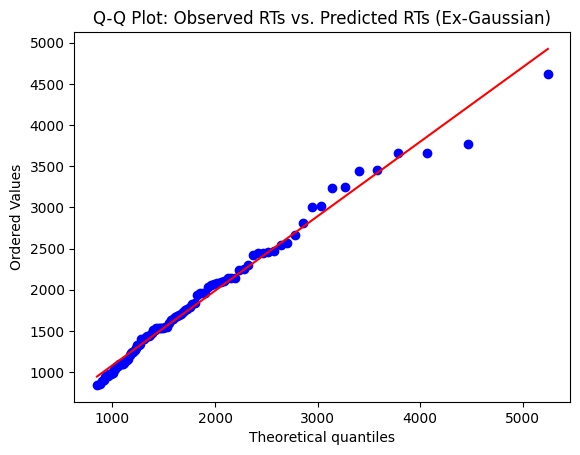

KS Stat: 0.052222222222222225, p-value: 0.9864049981121781


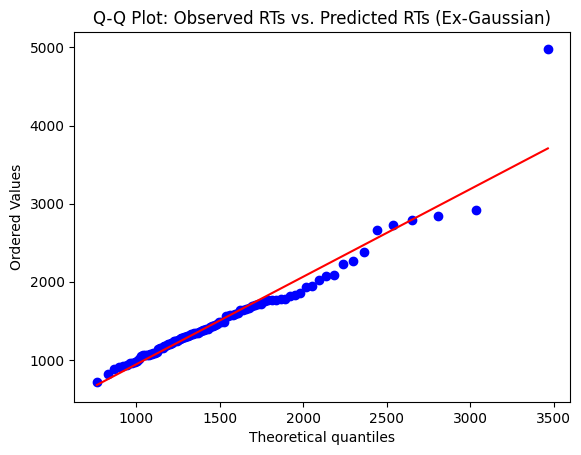

KS Stat: 0.05333333333333334, p-value: 0.9830650150917032


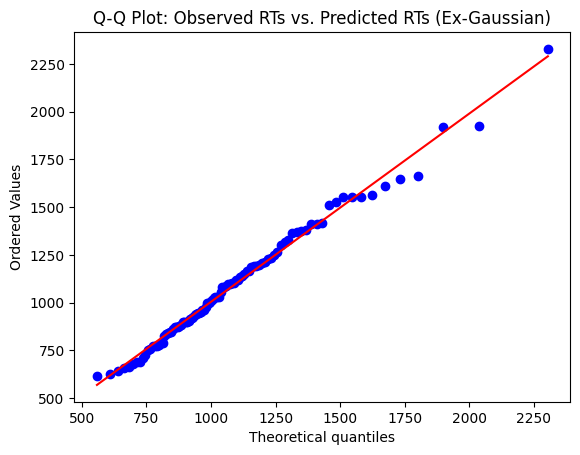

KS Stat: 0.045695067264573994, p-value: 0.996915976921053


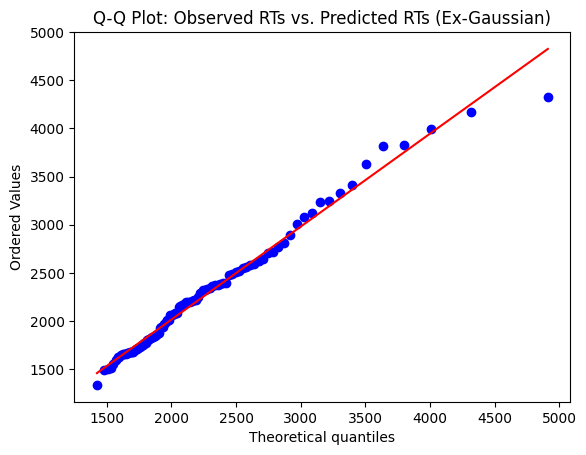

KS Stat: 0.06888888888888889, p-value: 0.8744351403296499


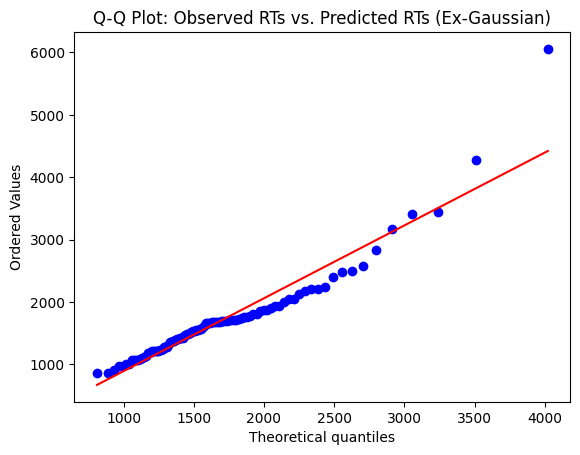

KS Stat: 0.08777777777777777, p-value: 0.627710541064128


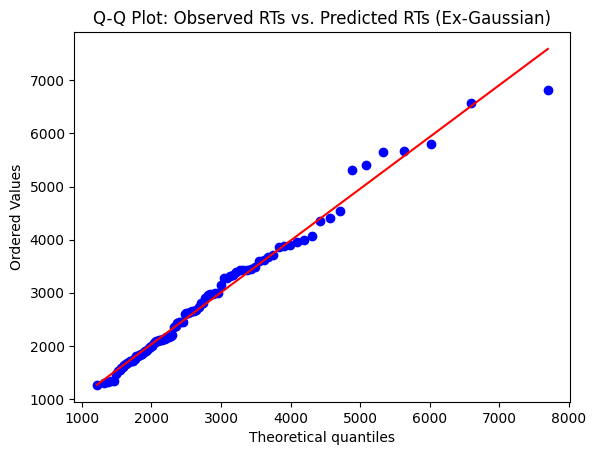

KS Stat: 0.09780269058295964, p-value: 0.48590851024161164


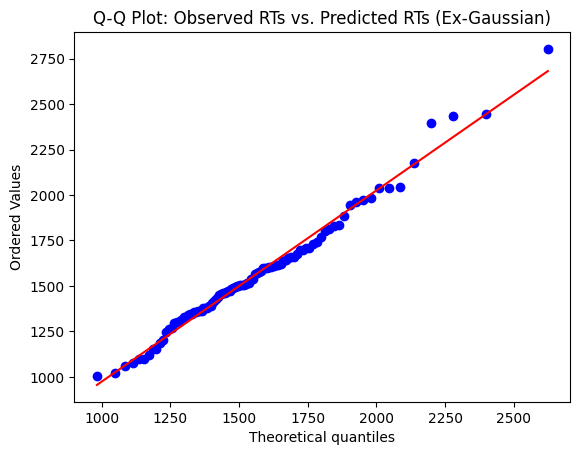

KS Stat: 0.057777777777777775, p-value: 0.9642412248781718


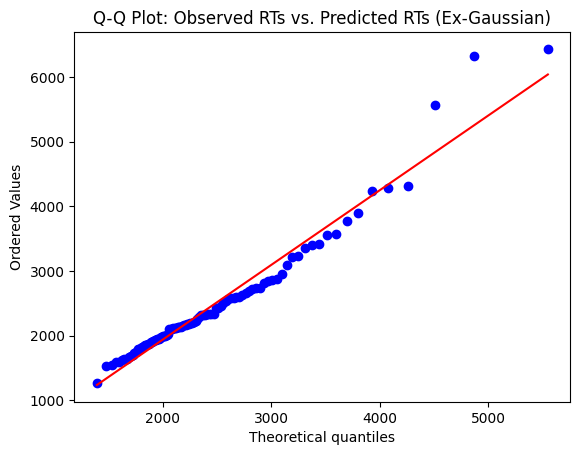

KS Stat: 0.10111111111111111, p-value: 0.4490332863594763


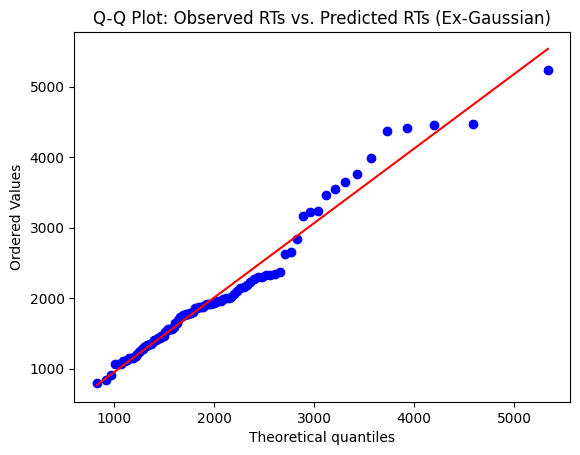

KS Stat: 0.09666666666666666, p-value: 0.5059949919419156


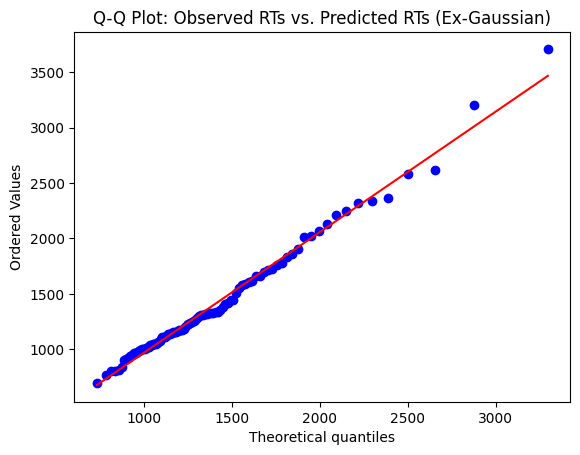

KS Stat: 0.05555555555555555, p-value: 0.9748371350563931


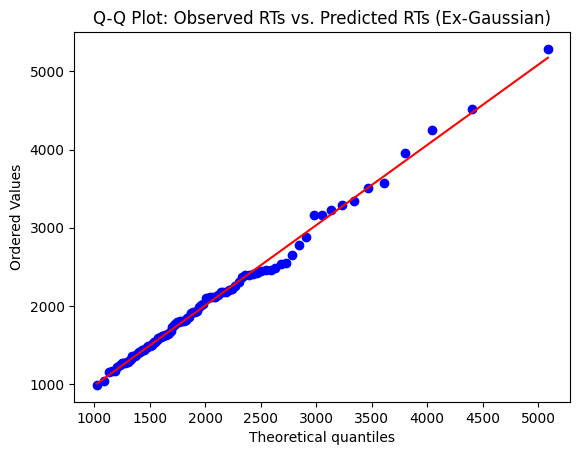

KS Stat: 0.09555555555555556, p-value: 0.5207288365172795


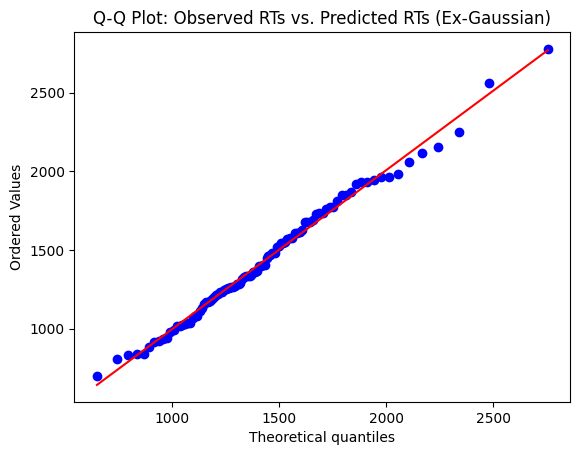

KS Stat: 0.08777777777777777, p-value: 0.627710541064128


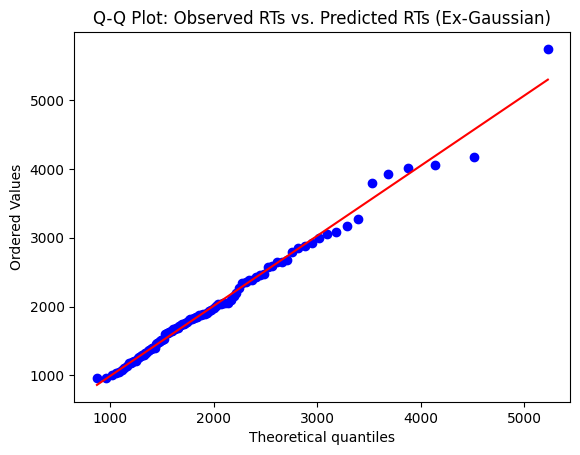

KS Stat: 0.07555555555555556, p-value: 0.7954026585469328


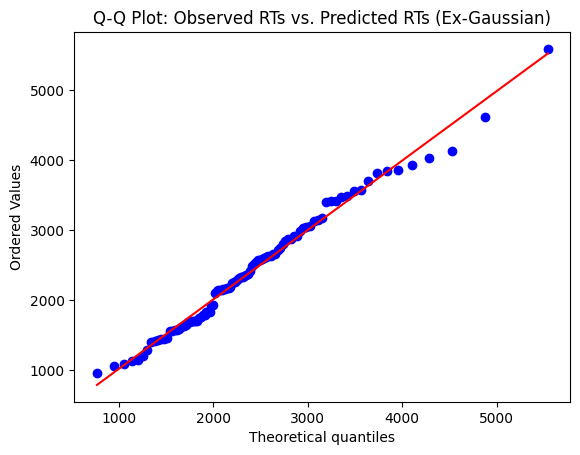

KS Stat: 0.07660714285714286, p-value: 0.776053286947219


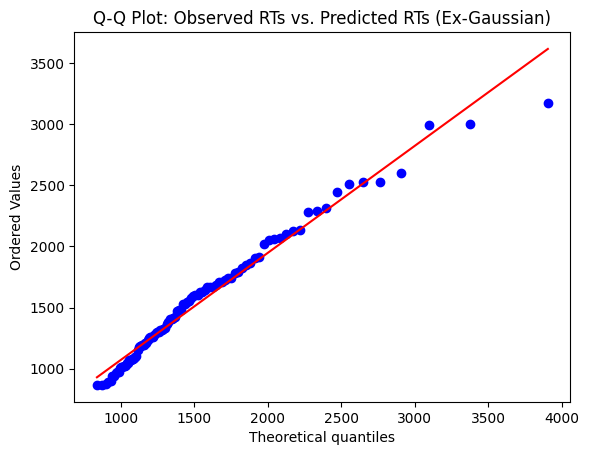

KS Stat: 0.09, p-value: 0.5966259064884945


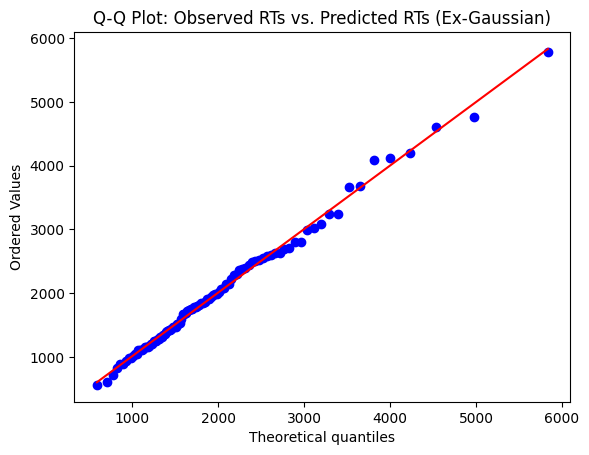

KS Stat: 0.09222222222222222, p-value: 0.5658858254827598


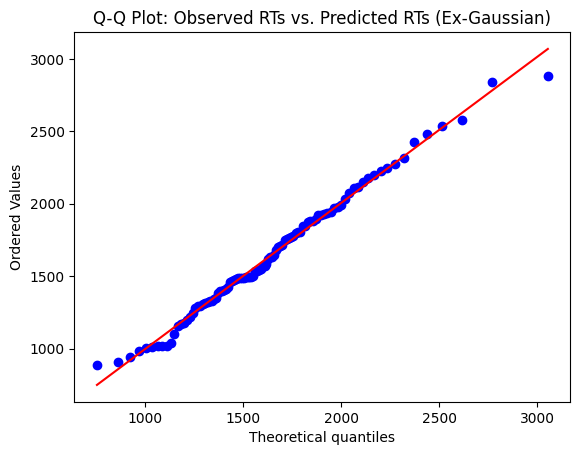

KS Stat: 0.058888888888888886, p-value: 0.9580136977985203


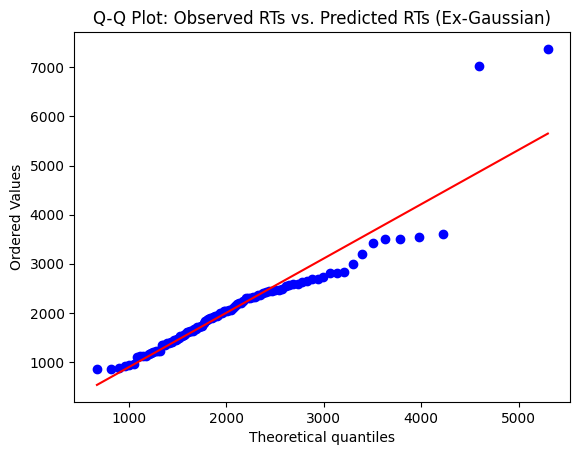

KS Stat: 0.0775, p-value: 0.7644628448477951


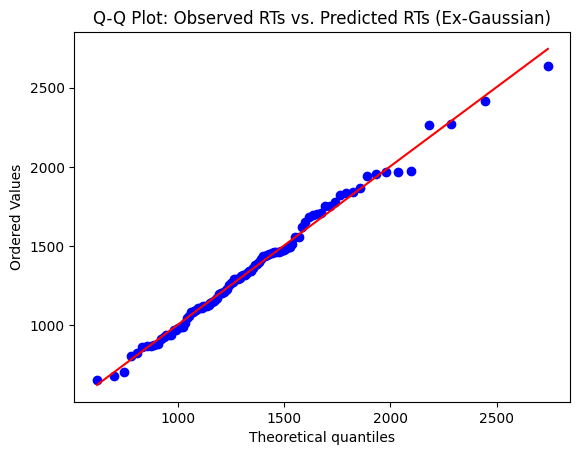

KS Stat: 0.09333333333333334, p-value: 0.5506849936169851


In [48]:
reaction_times_test_model_1 = get_reaction_times(all_data_test)

for i, participant in enumerate(all_data_test):
    predicted_reaction_time = exponnorm.rvs(results_model_1[i][2], results_model_1[i][0], results_model_1[i][1], size=len(all_data_test[participant]))
    
    ks_stat, p_value = ks_2samp(predicted_reaction_time, reaction_times_test_model_1[i])
    
    stats.probplot(reaction_times_test_model_1[i], dist=exponnorm, sparams=(results_model_1[i][2], results_model_1[i][0], results_model_1[i][1]), plot=plt)
    plt.title("Q-Q Plot: Observed RTs vs. Predicted RTs (Ex-Gaussian)")
    plt.show()
    
    print(f"KS Stat: {ks_stat}, p-value: {p_value}")

### Accuracy test for model 1

66.67733355097789
0.0
0.0
0.0


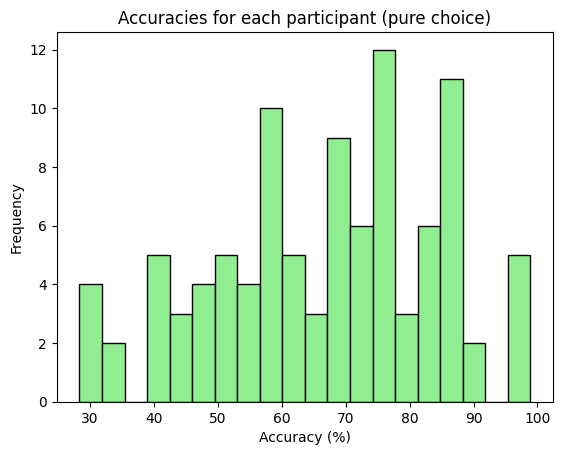

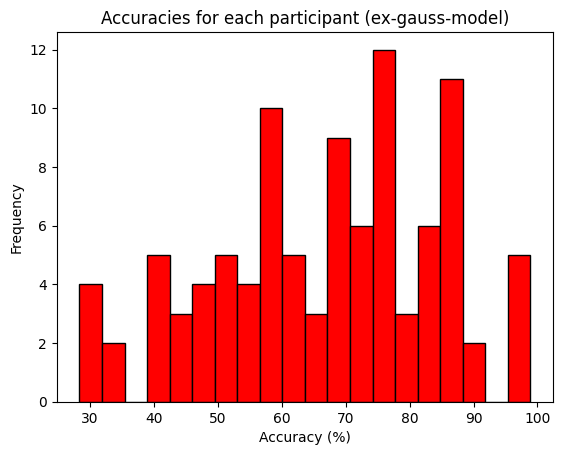

In [49]:
prediction_accuracies_model_1 = []

for i, participant in enumerate(all_data_test):
    accuracy_score = predict_accuracies(results_model_1[i][4], results_model_1[i][3], participant)
    prediction_accuracies_model_1.append(accuracy_score)

print(np.mean(prediction_accuracies_model_1))

print(min(prediction_accuracies) - min(prediction_accuracies_model_1))
print(np.mean(prediction_accuracies) - np.mean(prediction_accuracies_model_1))
print(max(prediction_accuracies) - max(prediction_accuracies_model_1))

plt.hist(prediction_accuracies_model_1, bins=20, color="lightgreen", edgecolor="black")
plt.title("Accuracies for each participant (pure choice)")
plt.xlabel("Accuracy (%)")
plt.ylabel("Frequency")
plt.show()

plt.hist(prediction_accuracies, bins=20, color="red", edgecolor="black")
plt.title("Accuracies for each participant (ex-gauss-model)")
plt.xlabel("Accuracy (%)")
plt.ylabel("Frequency")
plt.show()

---

# Model 2: LBA Model 

---

In [50]:
dataframes_train_unfiltered = []
dataframes_train = []

# Loop through each CSV file in the "ConvertedData" directory
for csv_file in os.listdir("ConvertedData/"):
    if csv_file.endswith("train.csv"):
        # Read the CSV file and append it to the unfiltered dataframes list
        dataframes_train_unfiltered.append(pd.read_csv(f"ConvertedData/{csv_file}"))

# Loop through each dataframe in the unfiltered dataframes list
for dataframe in dataframes_train_unfiltered:
    # Filter out rows where column "3" is 0
    dataframe = dataframe[dataframe["3"] != 0]
    
    # Replace values in column "3"
    dataframe["3"] = dataframe["3"].replace(1, 0)
    dataframe["3"] = dataframe["3"].replace(2, 1)
    
    # Convert values in column "6" to seconds by dividing by 1000
    dataframe["6"] = dataframe["6"]
    
    # Rename columns
    dataframe.rename(columns={"0": "immOutcome", "1": "delOut", "2": "delay", "3": "action", "4": "p_imm", "5": "condition", "6": "RT"}, inplace=True)
    
    # Append the processed dataframe to the filtered dataframes list
    dataframes_train.append(dataframe)


dataframes_test_unfiltered = []
dataframes_test = []

# Loop through each CSV file in the "ConvertedData" directory
for csv_file in os.listdir("ConvertedData/"):
    if csv_file.endswith("test.csv"):
        # Read the CSV file and append it to the unfiltered dataframes list
        dataframes_test_unfiltered.append(pd.read_csv(f"ConvertedData/{csv_file}"))

# Loop through each dataframe in the unfiltered dataframes list
for dataframe in dataframes_test_unfiltered:
    # Filter out rows where column "3" is 0
    dataframe = dataframe[dataframe["3"] != 0]
    
    # Replace values in column "3"
    dataframe["3"] = dataframe["3"].replace(1, 0)
    dataframe["3"] = dataframe["3"].replace(2, 1)
    
    # Convert values in column "6" to seconds by dividing by 1000
    dataframe["6"] = dataframe["6"]
    
    # Rename columns
    dataframe.rename(columns={"0": "immOutcome", "1": "delOut", "2": "delay", "3": "action", "4": "p_imm", "5": "condition", "6": "RT"}, inplace=True)
    
    # Append the processed dataframe to the filtered dataframes list
    dataframes_test.append(dataframe)

C:\Users\Nicla\AppData\Local\Temp\ipykernel_10632\2410340128.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["3"] = dataframe["3"].replace(1, 0)
C:\Users\Nicla\AppData\Local\Temp\ipykernel_10632\2410340128.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe["3"] = dataframe["3"].replace(2, 1)
C:\Users\Nicla\AppData\Local\Temp\ipykernel_10632\2410340128.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

In [51]:
def lba_pdf(rt, choice, v, A, b, t0, sv):
    # rt: response time
    # choice: chosen accumulator
    # v: drift rates for each accumulator
    # A: starting point variability
    # b: threshold
    # t0: non-decision time
    # sv: standard deviation of drift rates

    # Adjust response time for non-decision time
    rt_adj = rt - t0
    if rt_adj <= 0:
        return 0

    # Compute the probability density for the chosen accumulator
    drift = v[choice]
    F = norm.cdf((b - A) / (rt_adj + 1e-10), loc=drift, scale=sv)
    f = (drift / (sv + 1e-10)) * norm.pdf((b - A) / (rt_adj + 1e-10), loc=drift, scale=sv) / (rt_adj + 1e-10)

    return f * F

In [52]:
def neg_log_likelihood_old_v2(n, rt, v, A, t0):
    return -np.log(A / min(v[0], v[1])) - ((rt - t0) / (A / min(v[0], v[1])))

In [53]:
def neg_log_likelihood_old(params, data):
    # Unpack parameters
    v = params[:2]  # Assuming two accumulators
    A = params[2]
    b = params[3]
    t0 = params[4]
    sv = params[5]
    
    # Calculate negative log-likelihood
    nll = 0
    for rt, choice in data:
        p = lba_pdf(rt, choice, v, A, b, t0, sv)
        if p > 0:
            nll -= np.log(p)
        else:
            nll += 0 # war mal inf!!! - Penalize impossible parameter sets

    return nll

In [54]:
def neg_log_likelihood(rt, choice, v, A, b, s=1, t0=0):
    """
    Computes the log-likelihood of observed reaction times and choices 
    under the Linear Ballistic Accumulator (LBA) model.

    Parameters:
    - rt: array-like, reaction times in milliseconds.
    - choice: array-like, binary choices (0 for immediate, 1 for delayed).
    - v: dict, drift rates for each choice (e.g., {'immediate': 3, 'delayed': 2}).
    - A: float, range of starting point distribution.
    - b: float, response threshold.
    - s: float, standard deviation of drift rate (usually fixed at 1).
    - t0: float, non-decision time.

    Returns:
    - log_likelihood: float, sum of log-likelihoods across trials.
    """

    rt = np.asarray(rt) - t0  # Adjust reaction times for non-decision time
    
    _rt = [ reaction_time / 1000 for reaction_time in rt if reaction_time > 0 ]
    rt = _rt
    
    ll_total = 0
    for i in range(len(rt)):
        if i not in choice.keys():
            continue
        
        c = 'delayed' if choice[i] == 1 else 'immediate'
        c_alt = 'immediate' if choice[i] == 1 else 'delayed'

        v_winner = v[c]   # Drift rate for chosen option
        v_loser = v[c_alt]  # Drift rate for unchosen option

        # Probability density function of winning accumulator
        F = (b - v_winner * rt[i]) / A
        F = np.clip(F, -10, 10)  # Keep within valid probability range
        #f_winner = (v_winner / A) * norm.cdf(F) + (1 - norm.cdf(F))
        f_winner = (v_winner / A) * norm.cdf(F)
        f_winner = max(f_winner, 1e-10)

        # Survivor function of losing accumulator
        #S_loser = 1 - norm.cdf((b - v_loser * rt[i]) / A)
        S_loser = max(f_winner, 1e-10)

        # Likelihood for the trial
        likelihood = f_winner * S_loser
        
        likelihood = max(likelihood, 1e-10)  # Avoid log(0)
        
        ll_total += np.log(likelihood)

    return ll_total

Bounds fuer alles vor v3

In [ ]:
bounds = [
    (0, None),  # v1
    (0, None),  # v2
    (0, None),  # A
    (0, None),  # t0
    (1e-6, 1),  # k
    (1, 10)     # beta
]

In [ ]:
#for i in range(len(dataframes_train)):
#    data = dataframes_train[i][["RT", "action"]].values
#    data = [(float(row[0]), int(row[1])) for row in data]
#
#    result = minimize(neg_log_likelihood, initial_params, args=(data,), bounds=bounds)
#
#    if result.success:
#        fitted_params = result.x
#        print("Fitted parameters:", fitted_params)
#    else:
#        print("Optimization failed:", result.message)

In [ ]:
def lba_log_likelihood_v3(rt, choice, b, A, v, sv, t0):
    t = rt / 1000 - t0
    if t <= 0:
        return 0
    v_chosen = v if choice == 1 else -v
    z = (b - A) / (t * v_chosen)
    likelihood = (b / ((t0 ** 2) * sv)) * stats.norm.pdf(z, loc=0, scale=1)
    return np.log(likelihood)
    

Bounds (v3)

In [ ]:
bounds = [
    (0.01, 1.0),   # A: Maximum starting point
    (0.1, 5.0),    # b: Decision threshold
    (0.1, 10.0),   # v_scale: Drift rate scaling factor
    (0.01, 1.0),   # sv: Standard deviation of drift rate
    (0.01, 0.5),   # t0: Non-decision time
    (1e-6, 1.0),   # k: Discount rate
    (1, 10)        # beta
]

In [ ]:
def joint_log_likelihood_lba_train(params, data_set, participant, i):
    A, b, v_scale, sv, t0, k, beta = params
    
    log_L = 0
    
    # Initialize the log likelihood for the current participant
    Log_L_p_delay = 0
    
    # Get the data matrix for the current participant
    data_matrix = data_set[i]

    # Extract relevant columns from the data matrix
    sv_immediates = data_matrix["immOutcome"]
    delayed_outcomes = data_matrix["delOut"]
    delays = data_matrix["delay"]
    actions = data_matrix["action"]
    
    reaction_times_lba = data_matrix["RT"]
    
    log_L_lba = 0
    
    #v = {"immediate": v1, "delayed": v2}
    
    # Loop through each sample in the data matrix
    for j in range(len(dataframes_train[i])):
        rt_key = dataframes_train[i]["RT"].keys()[j]
        
        #log_L_lba += neg_log_likelihood(len(dataframes_train[i]), dataframes_train[i]["RT"][rt_key], [v1, v2], A, t0)
        #log_L_lba += neg_log_likelihood([reaction_times_lba[rt_key]], [actions[rt_key]], v, A, 1.5, 1, t0)
        log_L_lba += lba_log_likelihood_v3(reaction_times[rt_key], actions[rt_key], b, A, v_scale, sv, t0)
        
        # Calculate the subjective value of the delayed outcome
        sv_delayed = delayed_outcomes[rt_key] / (1.0 + k * max(delays[rt_key], 1e-10))
        
        # Calculate the probability of choosing the delayed outcome
        p_delayed = 1.0 / (1.0 + np.exp(-beta * (sv_delayed - sv_immediates[rt_key])))
        p_delayed = np.clip(p_delayed, 1e-10, 1.0 - 1e-10)
        
        # Update the log likelihood for the current participant
        Log_L_p_delay += actions[rt_key] * np.log(p_delayed) + (1.0 - actions[rt_key]) * np.log(1.0 - p_delayed)
    
    
    #log_L_lba += neg_log_likelihood(reaction_times_lba, actions, v, A, 1.5, 1, t0)
    
    # Update the overall log likelihood
    log_L += Log_L_p_delay
    log_L -= log_L_lba
    
    return -log_L

In [60]:
results_model_2 = []

for i, participant in enumerate(all_data_train):
    #initial_params = [1.0, 1.0, 1.5, 300, initial_k, initial_beta]
    initial_params = [0.5, 2, 1, 0.1, 0.2, initial_k, initial_beta]
     
    result = minimize(joint_log_likelihood_lba_train, initial_params, args=(dataframes_train, participant, i), bounds=bounds)
    results_model_2.append(result.x)
    print(result.x)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
for result in results_model_2:
    print(result, "\n")

[0.49999611 0.01       0.99999422 1.         0.5        0.01069519
 1.        ] 

[ 0.5000329   0.01        0.9999926   1.          0.5         0.01032269
 10.        ] 

[5.00003002e-01 1.00000000e-02 9.99996206e-01 1.00000000e+00
 5.00000000e-01 1.33954835e-03 4.56079235e+00] 

[5.00023854e-01 1.00000000e-02 9.99999852e-01 1.00000000e+00
 5.00000000e-01 9.85838777e-03 9.96774256e+00] 

[0.49998567 0.01       0.99998572 1.         0.5        0.00856448
 1.605975  ] 

[ 0.51142805  0.01        0.99697026  1.          0.5         0.54678878
 10.        ] 

[5.00045226e-01 1.00000000e-02 1.00000820e+00 1.00000000e+00
 5.00000000e-01 9.51531831e-03 1.00000000e+01] 

[4.99948841e-01 1.00000000e-02 9.99977263e-01 1.00000000e+00
 5.00000000e-01 1.09046761e-04 3.74954747e+00] 

[0.4999932  0.01       0.9999923  1.         0.5        0.00107514
 1.0000009 ] 

[0.49999245 0.01       0.99998279 1.         0.5        0.61127887
 1.        ] 

[5.00017366e-01 1.00000000e-02 1.00000396e+00 1.000000

---

# Testing Model 2

---

In [ ]:
for i, participant in enumerate(dataframes_test):
    starting_points = np.random.uniform(0, results_model_2[i][2], 1000)
    
    decision_times = (results_model_2[i][3] - starting_points) / min(results_model_2[i][0], results_model_2[i][1])
    
    predicted_reaction_times_lba = decision_times + results_model_2[i][4]
    
    #print(predicted_reaction_times_lba)
    
    #print("\n\n\n")
    
    reaction_times = dataframes_test[i]["RT"]
    
    ks_stat, p_value = ks_2samp(predicted_reaction_times_lba, reaction_times)
    
    print(f"KS Stat: {ks_stat}, p-value: {p_value}")

KS Stat: 1.0, p-value: 2.3784806539607393e-215
KS Stat: 1.0, p-value: 8.323463106064405e-218
KS Stat: 1.0, p-value: 8.323463106064405e-218
KS Stat: 1.0, p-value: 5.456492480642213e-217
KS Stat: 1.0, p-value: 8.323463106064405e-218
KS Stat: 1.0, p-value: 8.323463106064405e-218
KS Stat: 1.0, p-value: 8.323463106064405e-218
KS Stat: 1.0, p-value: 8.323463106064405e-218
KS Stat: 1.0, p-value: 8.323463106064405e-218
KS Stat: 1.0, p-value: 4.787581060669206e-212
KS Stat: 1.0, p-value: 8.323463106064405e-218
KS Stat: 1.0, p-value: 8.323463106064405e-218
KS Stat: 1.0, p-value: 5.456492480642213e-217
KS Stat: 1.0, p-value: 8.323463106064405e-218
KS Stat: 1.0, p-value: 8.323463106064405e-218
KS Stat: 1.0, p-value: 8.323463106064405e-218
KS Stat: 1.0, p-value: 3.593969069652046e-216
KS Stat: 1.0, p-value: 8.323463106064405e-218
KS Stat: 1.0, p-value: 8.323463106064405e-218
KS Stat: 1.0, p-value: 8.323463106064405e-218
KS Stat: 1.0, p-value: 8.323463106064405e-218
KS Stat: 1.0, p-value: 8.32346310

IndexError: list index out of range

---

# Model 3: DDM (In progress, currently not working as intended)

---

In [ ]:
def log_likelihood_ddm(params, data):
    v, a, z, t0 = params  # Unpack model parameters
    
    log_likelihood = 0

    for rt in data:
        # Time minus non-decision time (t0)
        rt_adjusted = (rt / 1000) - t0

        if rt_adjusted < 0:
            # If RT less t0 skip
            continue
        
        likelihood = norm.pdf(rt_adjusted, loc=a / (v + 1e-10), scale=1 / (np.sqrt(v) + 1e-10))  # Gaussian likelihood
        
        #if np.isnan(likelihood):
            #print(rt_adjusted, t0)
        
        log_likelihood += np.log(likelihood)

    return -log_likelihood  # Negative log-likelihood (to minimize)

In [ ]:
def joint_log_likelihood_ddm(params, data_set, participant, participant_id):
    v, a, z, t0, k, beta = params
    
    log_L = 0
    
    # Initialize the log likelihood for the current participant
    Log_L_p_delay = 0
    
    # Get the data matrix for the current participant
    data_matrix = data_set[participant_id]
    
    # Extract relevant columns from the data matrix
    sv_immediates = data_matrix["immOutcome"]
    delayed_outcomes = data_matrix["delOut"]
    delays = data_matrix["delay"]
    actions = data_matrix["action"]
    
    
    # Clamp action values to be between 0 and 1
    clamped_actions = action_values_clamp01(actions)
    
    log_L_ddm = log_likelihood_ddm(params=[v, a, z, t0], data=(dataframes_train[participant_id]["RT"]))
    
    # Loop through each sample in the data matrix
    for j in range(len(dataframes_train[participant_id])):
        rt_key = dataframes_train[participant_id]["RT"].keys()[j]
        action_key = int(dataframes_train[participant_id]["action"].keys()[j])
        
        # Calculate the subjective value of the delayed outcome
        sv_delayed = delayed_outcomes[rt_key] / (1.0 + k * max(delays[rt_key] / 1000, 1e-10))
        
        # Calculate the probability of choosing the delayed outcome
        p_delayed = 1.0 / (1.0 + np.exp(-beta * (sv_delayed - sv_immediates[rt_key])))
        p_delayed = np.clip(p_delayed, 1e-10, 1.0 - 1e-10)
        
        # Update the log likelihood for the current participant
        Log_L_p_delay += actions[action_key] * np.log(p_delayed) + (1.0 - actions[action_key]) * np.log(1.0 - p_delayed)
    
    # Update the overall log likelihood
    log_L += Log_L_p_delay
    log_L += log_L_ddm
    
    #print(f"\nlog_L_ddm: {log_L_ddm}")
    #print(f"log_L_p_delay: {Log_L_p_delay}")
    #print(f"log_L: {log_L}\n")
    
    return -log_L

In [ ]:
results_model_3 = []

bounds = [
    (1e-5, None),
    (0.01, None),
    (0, 1),
    (0, 1),
    (1e-6, 1),
    (1, 10)
]

for i, participant in enumerate(dataframes_train):
    initial_params = [0.5, 1.0, 0.5, 0.2, initial_k, initial_beta]
    
    result = minimize(joint_log_likelihood_ddm, initial_params, args=(dataframes_train, participant, i), bounds=bounds)
    results_model_3.append(result.x)
    print(result.x)

C:\Users\Nicla\AppData\Local\Temp\ipykernel_7708\719336310.py:19: RuntimeWarning: divide by zero encountered in log
  log_likelihood += np.log(likelihood)
z:\Programs\Python\CCS\.venv\lib\site-packages\scipy\optimize\_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


[5.000000e-01 1.000000e+00 5.000000e-01 2.000000e-01 2.370000e-04
 4.423591e+00]
[5.000000e-01 1.000000e+00 5.000000e-01 2.000000e-01 2.370000e-04
 4.423591e+00]
[5.26332095e+01 1.00000000e-02 5.00000000e-01 0.00000000e+00
 1.00000000e+00 1.00000000e+00]
[5.000000e-01 1.000000e+00 5.000000e-01 2.000000e-01 2.370000e-04
 4.423591e+00]
[5.000000e-01 1.000000e+00 5.000000e-01 2.000000e-01 2.370000e-04
 4.423591e+00]
[5.000000e-01 1.000000e+00 5.000000e-01 2.000000e-01 2.370000e-04
 4.423591e+00]
[5.000000e-01 1.000000e+00 5.000000e-01 2.000000e-01 2.370000e-04
 4.423591e+00]
[5.000000e-01 1.000000e+00 5.000000e-01 2.000000e-01 2.370000e-04
 4.423591e+00]
[5.000000e-01 1.000000e+00 5.000000e-01 2.000000e-01 2.370000e-04
 4.423591e+00]
[5.000000e-01 1.000000e+00 5.000000e-01 2.000000e-01 2.370000e-04
 4.423591e+00]
[5.000000e-01 1.000000e+00 5.000000e-01 2.000000e-01 2.370000e-04
 4.423591e+00]
[5.000000e-01 1.000000e+00 5.000000e-01 2.000000e-01 2.370000e-04
 4.423591e+00]
[5.000000e-01 1.

KeyboardInterrupt: 

---

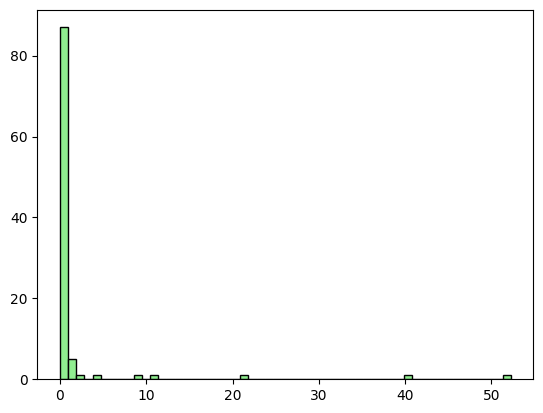

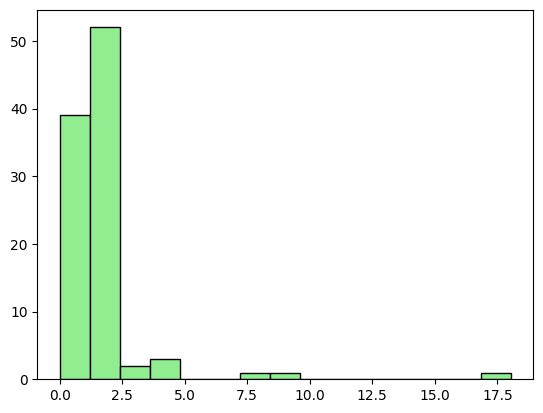

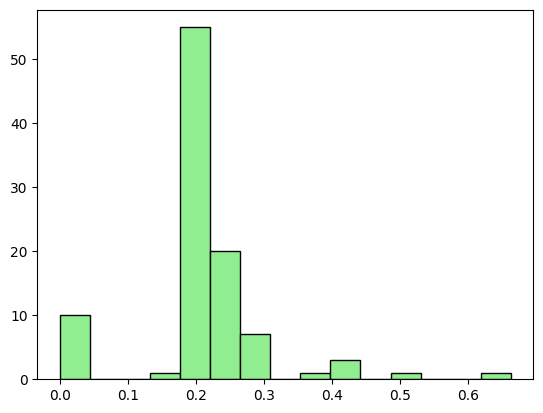

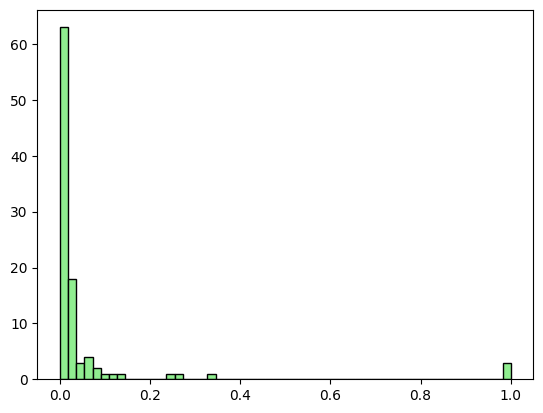

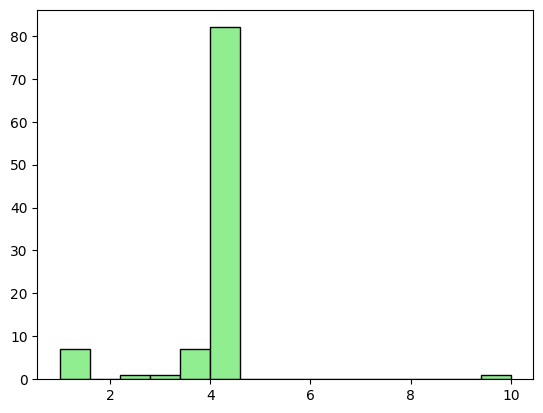

In [ ]:
v_values_model_3 = []
a_values_model_3 = []
t0_values_model_3 = []
k_values_model_3 = []
beta_values_model_3 = []

for result in results_model_3:
    v_values_model_3.append(result[0])
    a_values_model_3.append(result[1])
    t0_values_model_3.append(result[3])
    k_values_model_3.append(result[4])
    beta_values_model_3.append(result[5])


plt.hist(v_values_model_3, bins=55, color="lightgreen", edgecolor="black")
plt.show()

plt.hist(a_values_model_3, bins=15, color="lightgreen", edgecolor="black")
plt.show()

plt.hist(t0_values_model_3, bins=15, color="lightgreen", edgecolor="black")
plt.show()

plt.hist(k_values_model_3, bins=55, color="lightgreen", edgecolor="black")
plt.show()

plt.hist(beta_values_model_3, bins=15, color="lightgreen", edgecolor="black")
plt.show()

# Notes

### Deciding what to do with entries that are missing an action value (value = 0.0):
We decided to set the missing action values to 0.0 (immediate entry) for model 1

Joint likelihood bitti bitti

In [ ]:
def joint_log_likelihood_model_5(params, data_set, participant):
    log_L = 0
    k, beta, mu, sigma = params
    
    # Initialize the log likelihood for the current participant
    Log_L_p_delay = 0
    
    # Get the data matrix for the current participant
    data_matrix = data_set[participant]
    # Determine the sample size
    sample_size = len(data_matrix)
    # Extract relevant columns from the data matrix
    
    sv_immediates = data_matrix["immOutcome"]
    delayed_outcomes = data_matrix["delOutcome"]
    delays = data_matrix["delay"]
    actions = data_matrix["action (1=immediate, 2=delayed, 0=missing)"]
    reaction_times = data_matrix["RT"]
    
    # Clamp action values to be between 0 and 1
    clamped_actions = action_values_clamp01(actions)
    
    log_L_model_5 = 0
    
    # Loop through each sample in the data matrix
    for j in range(sample_size):
        log_L_model_5 += - np.log(reaction_times[j]) - 0.5 * np.log(2 * np.pi * sigma) - ((np.log(reaction_times[j]) - mu)**2) / (2 * (sigma**2))
        
        # Calculate the subjective value of the delayed outcome
        sv_delayed = delayed_outcomes[j] / (1.0 + k * max(delays[j], 1e-10))
        
        # Calculate the probability of choosing the delayed outcome
        p_delayed = 1.0 / (1.0 + np.exp(-beta * (sv_delayed - sv_immediates[j])))
        p_delayed = np.clip(p_delayed, 1e-10, 1.0 - 1e-10)
        
        # Update the log likelihood for the current participant
        Log_L_p_delay += clamped_actions[j] * np.log(p_delayed) + (1.0 - clamped_actions[j]) * np.log(1.0 - p_delayed)
    
    # Update the overall log likelihood
    log_L += Log_L_p_delay
    log_L += log_L_model_5
    
    #print(log_L_model_5, Log_L_p_delay)
    
    return -log_L

In [ ]:
def get_mean_of_log_of_reaction_times(dataset, participant):
    logs = 0
    
    reaction_times = dataset[participant]["RT"]
    
    for rt in reaction_times:
        logs += np.log(rt)
        
    mean = logs / len(reaction_times)

    return mean

In [ ]:
results_model_5 = []

log_mean = 0

for i, participant in enumerate(all_data_train):
    initial_params = [0.01, initial_beta, 7, 0.5]
    
    bounds = [
        (1e-6, 1), # bounds for k
        (0.1, 10), # bounds for beta
        (1, None), # bounds for mu
        (1e-6, None) # bounds for sigma
    ]
    
    #result = minimize(joint_log_likelihood_model_5, initial_params, args=(all_data_train, participant), bounds=bounds, method="Nelder-Mead")
    result = minimize(joint_log_likelihood_model_5, initial_params, args=(all_data_train, participant), bounds=bounds, method="L-BFGS-B")
    results_model_5.append(result.x)

C:\Users\Nicla\AppData\Local\Temp\ipykernel_7708\707174705.py:33: RuntimeWarning: overflow encountered in exp
  p_delayed = 1.0 / (1.0 + np.exp(-beta * (sv_delayed - sv_immediates[j])))


In [ ]:
reaction_times_test_model_5 = get_reaction_times(all_data_test)
p_values = []

for i, participant in enumerate(all_data_test):
    mu = results_model_5[i][2]
    sigma = results_model_5[i][3]
    
    predicted_reaction_time = np.random.lognormal(mean=mu, sigma=sigma, size=len(reaction_times_test_model_5[i]))
    
    #print(predicted_reaction_time)
    
    ks_stat, p_value = ks_2samp(predicted_reaction_time, reaction_times_test_model_5[i])
    
    #stats.probplot(reaction_times_test_model_5[i], dist="lognorm", sparams=(sigma, 0, np.exp(mu)), plot=plt)
    #plt.title("Q-Q Plot: Observed RTs vs. Predicted RTs (Model 5)")
    #plt.show()
    
    p_values.append(p_value)
    
    #print(f"KS Stat: {ks_stat}, p-value: {p_value}")

print(np.min(p_values))
    



0.0007377026282063397


### Accuracy test for the 

In [ ]:
def always_pick_option(participant, option):
    correct_guesses = 0
    
    actions = all_data_test[participant]["action (1=immediate, 2=delayed, 0=missing)"]
    
    clamped_actions = action_values_clamp01(actions)
    
    for i in range(len(clamped_actions)):
        if clamped_actions[i] == option:
            correct_guesses += 1
    
    return correct_guesses / len(clamped_actions) * 100
        

68.26399902213029
40.062752179876206
59.93724782012378


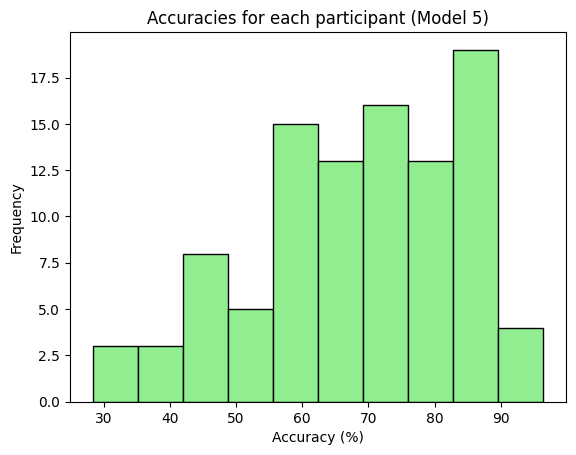

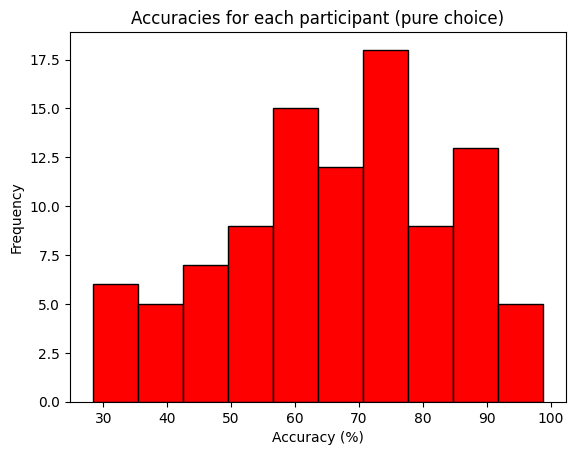

In [ ]:
prediction_accuracies_model_5 = []
immediate_accuracies_model_5 = []
delayed_accuracies_model_5 = []

for i, participant in enumerate(all_data_test):
    accuracy_score = predict_accuracies(results_model_5[i][0], results_model_5[i][1], participant)
    
    accuracy_score_always_immediate = always_pick_option(participant, 0)
    accuracy_score_always_delayed = always_pick_option(participant, 1)
    
    prediction_accuracies_model_5.append(accuracy_score)
    immediate_accuracies_model_5.append(accuracy_score_always_immediate)
    delayed_accuracies_model_5.append(accuracy_score_always_delayed)

print(np.mean(prediction_accuracies_model_5))
print(np.mean(immediate_accuracies_model_5))
print(np.mean(delayed_accuracies_model_5))

plt.hist(prediction_accuracies_model_5, bins=10, color="lightgreen", edgecolor="black")
plt.title("Accuracies for each participant (Model 5)")
plt.xlabel("Accuracy (%)")
plt.ylabel("Frequency")
plt.show()

plt.hist(prediction_accuracies, bins=10, color="red", edgecolor="black")
plt.title("Accuracies for each participant (pure choice)")
plt.xlabel("Accuracy (%)")
plt.ylabel("Frequency")
plt.show()

### MSE test

In [ ]:
for i, participant in enumerate(all_data_test):
    predicted_choices = predict_choices(results_model_5[i][0], results_model_5[i][1], participant)
    
    mse = 0
    sample_size = len(predicted_choices)
    
    for j in range(sample_size):
        mse += (all_data_test[participant]["RT"][j] - predict_choices[0])**2
        
    mse *= 1 / sample_size
    
    print(f"MSE ({i}): {mse}")

NameError: name 'results_model_5' is not defined